# GridWorld: Experiments - Policy Evaluation

In this notebook, we compare different policy evaluation results under different configurations for the ABC problem.

The setup was as follows:
  - Different problem sizes (L) were chosen
  - For each problem size, we chose a set of reward periods P
  - L and P make up one configuration
  - For each configuration, we executed 100 runs and computed the mean and std for RMSE and number of steps (for sanity check)
  - For each run, we do 10000 episodes simulating a specific mapping method. We do this for three methods: 
    - identity-mapper: regular policy evaluation with rewards for each step (i.e. P = 1)
    - reward-estimation-ls-mapper: simulate cumulative periodic reward (P > 1), and use least squares to estimate the rewards
    - reward-imputation-mapper: simulate cumuative periodic reward (P > 1), use 0 when rewards are missing
  

In [1]:
from exps import utils
import os.path
import json

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf

In [3]:
%matplotlib inline

In [4]:
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["font.size"] = 30

In [5]:
# Location of logs
LOGS = os.path.join(utils.read_file("exp-gridworld-eval-cpr_v2-output.txt"), "result-*")
PLOT_SIZE = (40, 10)

In [6]:
def load_grids(maps):
    grids = {}
    for key, path in maps.items():
        with tf.io.gfile.GFile(path, "r") as reader:
            grids[key] = "".join(reader.readlines())
    return grids

In [7]:
GRIDS = load_grids(utils.read_json("grid-maps.json"))

In [8]:
print(GRIDS["gridworld_01"])

sog


## Data Processing

Steps
  - Remove incomplete experiments (didn't reach 10k steps)
  - Remove configs with missing methods (e.g. ls-estimation failed)

In [9]:
df_results = utils.read_experiment_results(LOGS)

In [10]:
df_results

config method  episode  \
0     Lgridworld_cliff_06-P1     FR     1490   
1    Lgridworld_cliff_01-P16    S-M     9190   
2    Lgridworld_cliff_06-P16   ZI-M     4410   
3     Lgridworld_cliff_01-P8   ZI-M     6190   
4    Lgridworld_cliff_05-P16   ZI-M      450   
..                       ...    ...      ...   
789  Lgridworld_cliff_05-P16  LEAST     6770   
790   Lgridworld_cliff_05-P2   ZI-M     2370   
791         Lgridworld_01-P4   ZI-M     8430   
792        Lgridworld_04-P16    S-M     1740   
793   Lgridworld_cliff_06-P4   ZI-M     5370   

                                                  rmse  \
0    {'min': 253.29178147444895, 'max': 1411.688616...   
1    {'min': 3705.4959182274106, 'max': 5057.297104...   
2    {'min': 218.7086568074067, 'max': 777.81420500...   
3    {'min': 19.571904563485575, 'max': 50.21355274...   
4    {'min': 8108.504177713668, 'max': 10737.253280...   
..                                                 ...   
789  {'min': 352.26990495570294, 'max': 1564.345470...   
790  {'min': 417.894929228628, 'max': 2507.70891452...   
791  {'min': 0.21502749648419503, 'max': 2.07446195...   
792  {'min': 141.3076900994776, 'max': 180.99539768...   
793  {'min': 233.50081136101005, 'max': 710.3081197...   

                                            mean_error  \
0    {'min': 75.01177, 'max': 1291.5682, 'mean': 77...   
1    {'min': -3842.5625, 'max': -2820.3613, 'mean':...   
2    {'min': -342.79642, 'max': 687.5584, 'mean': 1...   
3    {'min': -30.185492, 'max': 26.66629, 'mean': -...   
4    {'min': 7756.1006, 'max': 10285.136, 'mean': 8...   
..                                                 ...   
789  {'min': -1059.1348, 'max': 1467.4308, 'mean': ...   
790  {'min': -642.9441, 'max': 2336.4885, 'mean': 7...   
791  {'min': -0.6375449999999999, 'max': 1.4039803,...   
792  {'min': -148.48978, 'max': -111.390564, 'mean'...   
793  {'min': -540.5395, 'max': 586.51105, 'mean': 1...   

                                          pearson_corr  \
0    {'min': 0.995104, 'max': 0.9983888, 'mean': 0....   
1    {'min': 0.88788515, 'max': 0.9228807, 'mean': ...   
2    {'min': 0.9948918999999999, 'max': 0.998415899...   
3    {'min': 0.88541305, 'max': 0.9949302999999999,...   
4    {'min': 0.9824221, 'max': 0.9976710999999999, ...   
..                                                 ...   
789  {'min': 0.99147904, 'max': 0.99905574, 'mean':...   
790  {'min': 0.99073076, 'max': 0.99898285, 'mean':...   
791  {'min': 0.9784181, 'max': 0.9993584, 'mean': 0...   
792  {'min': 0.9774516, 'max': 0.9852209, 'mean': 0...   
793  {'min': 0.9947782, 'max': 0.9983393500000001, ...   

                                         spearman_corr  \
0    {'min': 0.9891581026525781, 'max': 0.997056276...   
1    {'min': 0.9363361552233781, 'max': 0.966298912...   
2    {'min': 0.9857688305230561, 'max': 0.995262463...   
3    {'min': 0.9045095759606651, 'max': 0.985400676...   
4    {'min': 0.9773268005411041, 'max': 0.995524155...   
..                                                 ...   
789  {'min': 0.9901454683924571, 'max': 0.997891422...   
790  {'min': 0.989372483396395, 'max': 0.9971023333...   
791  {'min': 0.9482765123334781, 'max': 0.974307632...   
792  {'min': 0.9911075018620151, 'max': 0.996617395...   
793  {'min': 0.9870734338219681, 'max': 0.995588614...   

                                                qtable  
0    {'min': [[-11761.5634765625, -11596.078125, -1...  
1    {'min': [[-7570.2470703125, -6364.94091796875,...  
2    {'min': [[-12295.451171875, -12167.5908203125,...  
3    {'min': [[-328.27734375, -208.39053344726562, ...  
4    {'min': [[-12568.6640625, -12476.6025390625, -...  
..                                                 ...  
789  {'min': [[-22457.611328125, -22415.55859375, -...  
790  {'min': [[-22415.04296875, -22323.595703125, -...  
791  {'min': [[-14.610190391540527, -10.63417434692...  
792  {'min': [[-561.218505859375, -543.903991699218...  
793  {'min': [[-12444.54589843

In [11]:
configs_to_exclude = utils.incomplete_or_missing_results(
    df_results, num_expected_alternatives=None
)

In [12]:
configs_to_exclude

set()

In [13]:
df_filtered_results = utils.filter_configs_from_results(df_results, configs_to_exclude)

In [14]:
df_filtered_results

config method  episode  \
0     Lgridworld_cliff_06-P1     FR     1490   
1    Lgridworld_cliff_01-P16    S-M     9190   
2    Lgridworld_cliff_06-P16   ZI-M     4410   
3     Lgridworld_cliff_01-P8   ZI-M     6190   
4    Lgridworld_cliff_05-P16   ZI-M      450   
..                       ...    ...      ...   
789  Lgridworld_cliff_05-P16  LEAST     6770   
790   Lgridworld_cliff_05-P2   ZI-M     2370   
791         Lgridworld_01-P4   ZI-M     8430   
792        Lgridworld_04-P16    S-M     1740   
793   Lgridworld_cliff_06-P4   ZI-M     5370   

                                                  rmse  \
0    {'min': 253.29178147444895, 'max': 1411.688616...   
1    {'min': 3705.4959182274106, 'max': 5057.297104...   
2    {'min': 218.7086568074067, 'max': 777.81420500...   
3    {'min': 19.571904563485575, 'max': 50.21355274...   
4    {'min': 8108.504177713668, 'max': 10737.253280...   
..                                                 ...   
789  {'min': 352.26990495570294, 'max': 1564.345470...   
790  {'min': 417.894929228628, 'max': 2507.70891452...   
791  {'min': 0.21502749648419503, 'max': 2.07446195...   
792  {'min': 141.3076900994776, 'max': 180.99539768...   
793  {'min': 233.50081136101005, 'max': 710.3081197...   

                                            mean_error  \
0    {'min': 75.01177, 'max': 1291.5682, 'mean': 77...   
1    {'min': -3842.5625, 'max': -2820.3613, 'mean':...   
2    {'min': -342.79642, 'max': 687.5584, 'mean': 1...   
3    {'min': -30.185492, 'max': 26.66629, 'mean': -...   
4    {'min': 7756.1006, 'max': 10285.136, 'mean': 8...   
..                                                 ...   
789  {'min': -1059.1348, 'max': 1467.4308, 'mean': ...   
790  {'min': -642.9441, 'max': 2336.4885, 'mean': 7...   
791  {'min': -0.6375449999999999, 'max': 1.4039803,...   
792  {'min': -148.48978, 'max': -111.390564, 'mean'...   
793  {'min': -540.5395, 'max': 586.51105, 'mean': 1...   

                                          pearson_corr  \
0    {'min': 0.995104, 'max': 0.9983888, 'mean': 0....   
1    {'min': 0.88788515, 'max': 0.9228807, 'mean': ...   
2    {'min': 0.9948918999999999, 'max': 0.998415899...   
3    {'min': 0.88541305, 'max': 0.9949302999999999,...   
4    {'min': 0.9824221, 'max': 0.9976710999999999, ...   
..                                                 ...   
789  {'min': 0.99147904, 'max': 0.99905574, 'mean':...   
790  {'min': 0.99073076, 'max': 0.99898285, 'mean':...   
791  {'min': 0.9784181, 'max': 0.9993584, 'mean': 0...   
792  {'min': 0.9774516, 'max': 0.9852209, 'mean': 0...   
793  {'min': 0.9947782, 'max': 0.9983393500000001, ...   

                                         spearman_corr  \
0    {'min': 0.9891581026525781, 'max': 0.997056276...   
1    {'min': 0.9363361552233781, 'max': 0.966298912...   
2    {'min': 0.9857688305230561, 'max': 0.995262463...   
3    {'min': 0.9045095759606651, 'max': 0.985400676...   
4    {'min': 0.9773268005411041, 'max': 0.995524155...   
..                                                 ...   
789  {'min': 0.9901454683924571, 'max': 0.997891422...   
790  {'min': 0.989372483396395, 'max': 0.9971023333...   
791  {'min': 0.9482765123334781, 'max': 0.974307632...   
792  {'min': 0.9911075018620151, 'max': 0.996617395...   
793  {'min': 0.9870734338219681, 'max': 0.995588614...   

                                                qtable  
0    {'min': [[-11761.5634765625, -11596.078125, -1...  
1    {'min': [[-7570.2470703125, -6364.94091796875,...  
2    {'min': [[-12295.451171875, -12167.5908203125,...  
3    {'min': [[-328.27734375, -208.39053344726562, ...  
4    {'min': [[-12568.6640625, -12476.6025390625, -...  
..                                                 ...  
789  {'min': [[-22457.611328125, -22415.55859375, -...  
790  {'min': [[-22415.04296875, -22323.595703125, -...  
791  {'min': [[-14.610190391540527, -10.63417434692...  
792  {'min': [[-561.218505859375, -543.903991699218...  
793  {'min': [[-12444.54589843

## Overview

Let's try and plot of the results to see what we get.

In [15]:
utils.slice_config(df_filtered_results, "Lgridworld_03-P2")

index            config method  episode  \
0       752  Lgridworld_03-P2   ZI-M        0   
1       592  Lgridworld_03-P2  LEAST        0   
2       803  Lgridworld_03-P2    S-M        0   
3        66  Lgridworld_03-P2   ZI-M       10   
4       232  Lgridworld_03-P2    S-M       10   
...     ...               ...    ...      ...   
2995    317  Lgridworld_03-P2   ZI-M     9980   
2996    285  Lgridworld_03-P2    S-M     9980   
2997    194  Lgridworld_03-P2    S-M     9990   
2998    813  Lgridworld_03-P2  LEAST     9990   
2999    732  Lgridworld_03-P2   ZI-M     9990   

                                                   rmse  \
0     {'min': 200.10414280756407, 'max': 200.9767554...   
1     {'min': 201.00513053153642, 'max': 201.0051305...   
2     {'min': 200.18436814596689, 'max': 200.9868426...   
3     {'min': 194.5683523854792, 'max': 199.69034622...   
4     {'min': 196.38461744431513, 'max': 199.7175153...   
...                                                 ...   
2995  {'min': 3.546337607924875, 'max': 12.044588537...   
2996  {'min': 163.41723703261843, 'max': 213.1061300...   
2997  {'min': 162.39416024367995, 'max': 213.7555554...   
2998  {'min': 3.782865825341821, 'max': 12.214543313...   
2999  {'min': 3.953458990530587, 'max': 11.246131740...   

                                             mean_error  \
0     {'min': 185.81319, 'max': 186.56013, 'mean': 1...   
1     {'min': 186.59302, 'max': 186.59302, 'mean': 1...   
2     {'min': 185.90335, 'max': 186.57468, 'mean': 1...   
3     {'min': 180.79268, 'max': 185.37201, 'mean': 1...   
4     {'min': 182.53343, 'max': 185.45905, 'mean': 1...   
...                                                 ...   
2995  {'min': -10.3355055, 'max': 9.308662, 'mean': ...   
2996  {'min': -200.29077, 'max': -149.85858, 'mean':...   
2997  {'min': -200.4576, 'max': -148.57407, 'mean': ...   
2998  {'min': -5.771575, 'max': 11.119144, 'mean': 1...   
2999  {'min': -9.521328, 'max': 8.839141, 'mean': 1....   

                                           pearson_corr  \
0     {'min': -0.25116152, 'max': 0.8059622, 'mean':...   
1     {'min': None, 'max': None, 'mean': None, 'std'...   
2     {'min': -0.24806078, 'max': 0.75962836, 'mean'...   
3     {'min': 0.7106836, 'max': 0.9806802, 'mean': 0...   
4     {'min': 0.6996878999999999, 'max': 0.9388654, ...   
...                                                 ...   
2995  {'min': 0.99607915, 'max': 0.99890816, 'mean':...   
2996  {'min': 0.99686176, 'max': 0.998946, 'mean': 0...   
2997  {'min': 0.9962141, 'max': 0.9987286999999999, ...   
2998  {'min': 0.99394435, 'max': 0.9989124500000001,...   
2999  {'min': 0.99641466, 'max': 0.99886316, 'mean':...   

                                          spearman_corr  \
0     {'min': -0.38236063993170005, 'max': 0.9154784...   
1     {'min': 0.0, 'max': 0.0, 'mean': 0.0, 'std': 0.0}   
2     {'min': -0.387625614299268, 'max': 0.869985569...   
3     {'min': 0.674844727135757, 'max': 0.9856554910...   
4     {'min': 0.5624006921937951, 'max': 0.971135115...   
...                                                 ...   
2995  {'min': 0.990571449078194, 'max': 0.9967467138...   
2996  {'min': 0.99033491607412, 'max': 0.99705589041...   
2997  {'min': 0.9912510566536851, 'max': 0.997520485...   
2998  {'min': 0.9901381887461851, 'max': 0.997196934...   
2999  {'min': 0.9919834601602231, 'max': 0.997080794...   

                                                 qtable  
0     {'min': [[-2.344403743743896, -1.6830701828002...  
1     {'min': [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0,...  
2     {'min': [[-1.977185249328613, -1.8672010898590...  
3     {'min': [[-9.143911361694336, -9.1377820968627...  
4     {'min': [[-8.539876937866211, -8.6325292587280...  
...                                                 ...  
2995  {'min': [[-278.9517822265625, -276.65869140625...  
2996  {'min': [[-542.4840087890625, -539.103515625, ...  
2997  {'min': [[-545.24853515625, -537.76806640625, ...  
2

In [16]:
utils.slice_config(df_filtered_results, "Lgridworld_03-P2").iloc[0, :]["rmse"]

{'min': 200.10414280756407,
 'max': 200.97675549674892,
 'mean': 200.7771586945126,
 'std': 0.18369367760652103}

<AxesSubplot:title={'center':'Level=gridworld_03,P=2'}, xlabel='Episode', ylabel='rmse'>

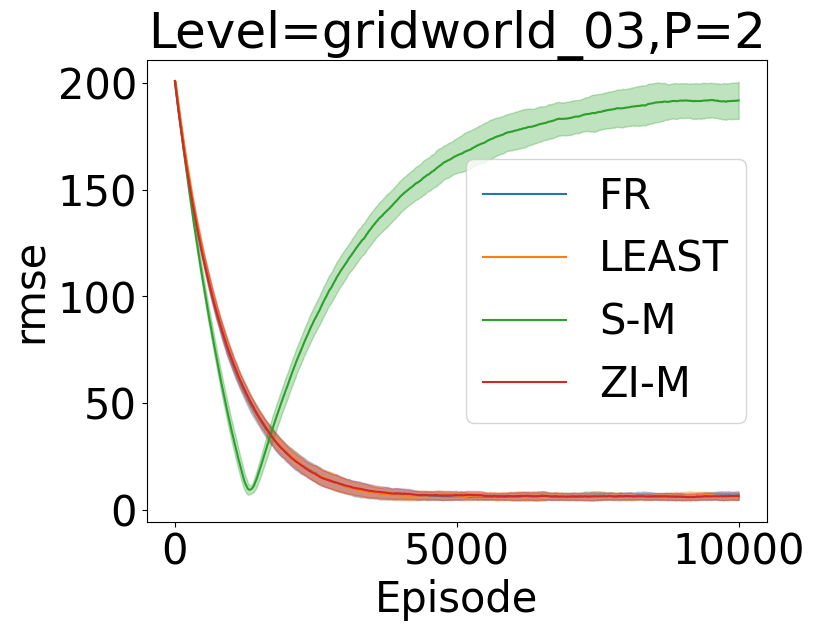

In [17]:
utils.plot_config_comparison(df_filtered_results, "Lgridworld_03-P2")

We can make it easier to filter by a problem or reward period P.

In [18]:
df_final = utils.expand_for_lookup(df_filtered_results)

In [19]:
df_final.sort_values(by=["P", "L"])

config method  episode  \
150         Lgridworld_01-P1     FR     6750   
56          Lgridworld_01-P1     FR     4380   
59          Lgridworld_01-P1     FR     7370   
160         Lgridworld_01-P1     FR     7970   
266         Lgridworld_01-P1     FR     3540   
..                       ...    ...      ...   
737  Lgridworld_cliff_06-P16    S-M     4270   
740  Lgridworld_cliff_06-P16   ZI-M     8130   
752  Lgridworld_cliff_06-P16    S-M     7400   
780  Lgridworld_cliff_06-P16  LEAST     6660   
783  Lgridworld_cliff_06-P16    S-M     4190   

                                                  rmse  \
150  {'min': 0.23710900547055302, 'max': 1.75282386...   
56   {'min': 0.23190985307154902, 'max': 1.83454933...   
59   {'min': 0.18141421697307802, 'max': 1.62731094...   
160  {'min': 0.2977240993235, 'max': 2.125732632171...   
266  {'min': 0.185608592560557, 'max': 1.6455906878...   
..                                                 ...   
737  {'min': 44587.20318656464, 'max': 54879.272298...   
740  {'min': 244.69125156766435, 'max': 982.7938809...   
752  {'min': 74233.6549012643, 'max': 87413.5718524...   
780  {'min': 227.6798996809995, 'max': 668.67310305...   
783  {'min': 44438.83562831052, 'max': 53840.539670...   

                                            mean_error  \
150  {'min': -1.1507615, 'max': 1.2776045, 'mean': ...   
56   {'min': -1.0340847, 'max': 1.3745295, 'mean': ...   
59   {'min': -1.2250942, 'max': 1.1541454, 'mean': ...   
160  {'min': -0.9696859999999999, 'max': 1.508242, ...   
266  {'min': -1.101453, 'max': 1.2336869, 'mean': 0...   
..                                                 ...   
737  {'min': -45033.953, 'max': -35658.73, 'mean': ...   
740  {'min': -479.57822, 'max': 877.7537, 'mean': 1...   
752  {'min': -77370.26, 'max': -65704.58, 'mean': -...   
780  {'min': -538.00134, 'max': 559.22577, 'mean': ...   
783  {'min': -44014.984, 'max': -35435.223, 'mean':...   

                                          pearson_corr  \
150  {'min': 0.9794636, 'max': 0.999705, 'mean': 0....   
56   {'min': 0.97997946, 'max': 0.9996320999999999,...   
59   {'min': 0.9828787999999999, 'max': 0.99955136,...   
160  {'min': 0.9756781, 'max': 0.99925154, 'mean': ...   
266  {'min': 0.9776098999999999, 'max': 0.9996613, ...   
..                                                 ...   
737  {'min': 0.9662819500000001, 'max': 0.984506999...   
740  {'min': 0.9955757, 'max': 0.9983683, 'mean': 0...   
752  {'min': 0.98969555, 'max': 0.99698293, 'mean':...   
780  {'min': 0.9951749999999999, 'max': 0.998252199...   
783  {'min': 0.9637291, 'max': 0.9844145, 'mean': 0...   

                                         spearman_corr  \
150  {'min': 0.974307632279887, 'max': 0.9743076322...   
56   {'min': 0.9482765123334781, 'max': 0.974307632...   
59   {'min': 0.974307632279887, 'max': 0.9743076322...   
160  {'min': 0.974307632279887, 'max': 0.9743076322...   
266  {'min': 0.974307632279887, 'max': 0.9743076322...   
..                                                 ...   
737  {'min': 0.9773171638818181, 'max': 0.990205947...   
740  {'min': 0.9873819548723871, 'max': 0.996320250...   
752  {'min': 0.979309547712064, 'max': 0.9915371422...   
780  {'min': 0.9899470870344381, 'max': 0.996743365...   
783  {'min': 0.9801911334776601, 'max': 0.989818050...   

                                                qtable                   L   P  
150  {'min': [[-14.968957901000977, -11.46393013000...        gridworld_01   1  
56   {'min': [[-15.942193031311035, -11.23039436340...        gridworld_01   1  
59   {'min': [[-15.408100128173828, -11.92739677429...        gridworld_01   1  
160  {'min': [[-14.95436954498291, -11.611620903015...        gridworld_01   1  
266  {'min': [[-15.279834747314453, -11.79841613769...        gridworld_01   1  
..                                                 ...                 ...  ..  
737  {'min': [[-97761.6796875, -92083.890625, -9706...  gridworld_cliff_06  16  
740  {'mi

In [20]:
sorted(df_final[df_final["P"] > 1]["P"].unique())

[2, 4, 8, 16]

In [21]:
df_final[["P", "L"]].drop_duplicates().sort_values(by=["P", "L"])

P                   L
150   1        gridworld_01
36    1        gridworld_02
17    1        gridworld_03
161   1        gridworld_04
265   1  gridworld_cliff_01
64    1  gridworld_cliff_02
163   1  gridworld_cliff_03
9     1  gridworld_cliff_04
16    1  gridworld_cliff_05
0     1  gridworld_cliff_06
43    2        gridworld_01
6     2        gridworld_02
97    2        gridworld_03
65    2        gridworld_04
41    2  gridworld_cliff_01
8     2  gridworld_cliff_02
37    2  gridworld_cliff_03
15    2  gridworld_cliff_04
5     2  gridworld_cliff_05
11    2  gridworld_cliff_06
83    4        gridworld_01
27    4        gridworld_02
38    4        gridworld_03
32    4        gridworld_04
72    4  gridworld_cliff_01
25    4  gridworld_cliff_02
33    4  gridworld_cliff_03
257   4  gridworld_cliff_04
57    4  gridworld_cliff_05
56    4  gridworld_cliff_06
7     8        gridworld_01
40    8        gridworld_02
34    8        gridworld_03
23    8        gridworld_04
3     8  gridworld_cliff_01
133   8  gridworld_cliff_02
226   8  gridworld_cliff_03
67    8  gridworld_cliff_04
12    8  gridworld_cliff_05
98    8  gridworld_cliff_06
10   16        gridworld_01
94   16        gridworld_02
112  16        gridworld_03
58   16        gridworld_04
1    16  gridworld_cliff_01
22   16  gridworld_cliff_02
79   16  gridworld_cliff_03
29   16  gridworld_cliff_04
4    16  gridworld_cliff_05
2    16  gridworld_cliff_06

**Results Tables**

In [22]:
utils.table_config_comparison(df_final, "Lgridworld_03-P16")

config method  episode       rmse ± std rmse (mean)  \
999   Lgridworld_03-P16     FR     9990      6.558±2.079       6.558   
2999  Lgridworld_03-P16  LEAST     9990      6.498±1.904       6.498   
2998  Lgridworld_03-P16    S-M     9990  1541.833±23.052    1541.833   
2997  Lgridworld_03-P16   ZI-M     9990       6.389±1.76       6.389   

     rmse (std)  
999       2.079  
2999      1.904  
2998     23.052  
2997       1.76

**Experiments**

In [23]:
experiments = utils.get_experiment_configs(df_final)

In [24]:
experiments

{'gridworld_01': [1, 2, 4, 8, 16],
 'gridworld_02': [1, 2, 4, 8, 16],
 'gridworld_03': [1, 2, 4, 8, 16],
 'gridworld_04': [1, 2, 4, 8, 16],
 'gridworld_cliff_01': [1, 2, 4, 8, 16],
 'gridworld_cliff_02': [1, 2, 4, 8, 16],
 'gridworld_cliff_03': [1, 2, 4, 8, 16],
 'gridworld_cliff_04': [1, 2, 4, 8, 16],
 'gridworld_cliff_05': [1, 2, 4, 8, 16],
 'gridworld_cliff_06': [1, 2, 4, 8, 16]}

In [25]:
sorted(experiments.items(), key=lambda kv: kv[0])

[('gridworld_01', [1, 2, 4, 8, 16]),
 ('gridworld_02', [1, 2, 4, 8, 16]),
 ('gridworld_03', [1, 2, 4, 8, 16]),
 ('gridworld_04', [1, 2, 4, 8, 16]),
 ('gridworld_cliff_01', [1, 2, 4, 8, 16]),
 ('gridworld_cliff_02', [1, 2, 4, 8, 16]),
 ('gridworld_cliff_03', [1, 2, 4, 8, 16]),
 ('gridworld_cliff_04', [1, 2, 4, 8, 16]),
 ('gridworld_cliff_05', [1, 2, 4, 8, 16]),
 ('gridworld_cliff_06', [1, 2, 4, 8, 16])]

## Fix problem, increase reward period

### GridWorld 01


In [26]:
print(GRIDS["gridworld_01"])

sog


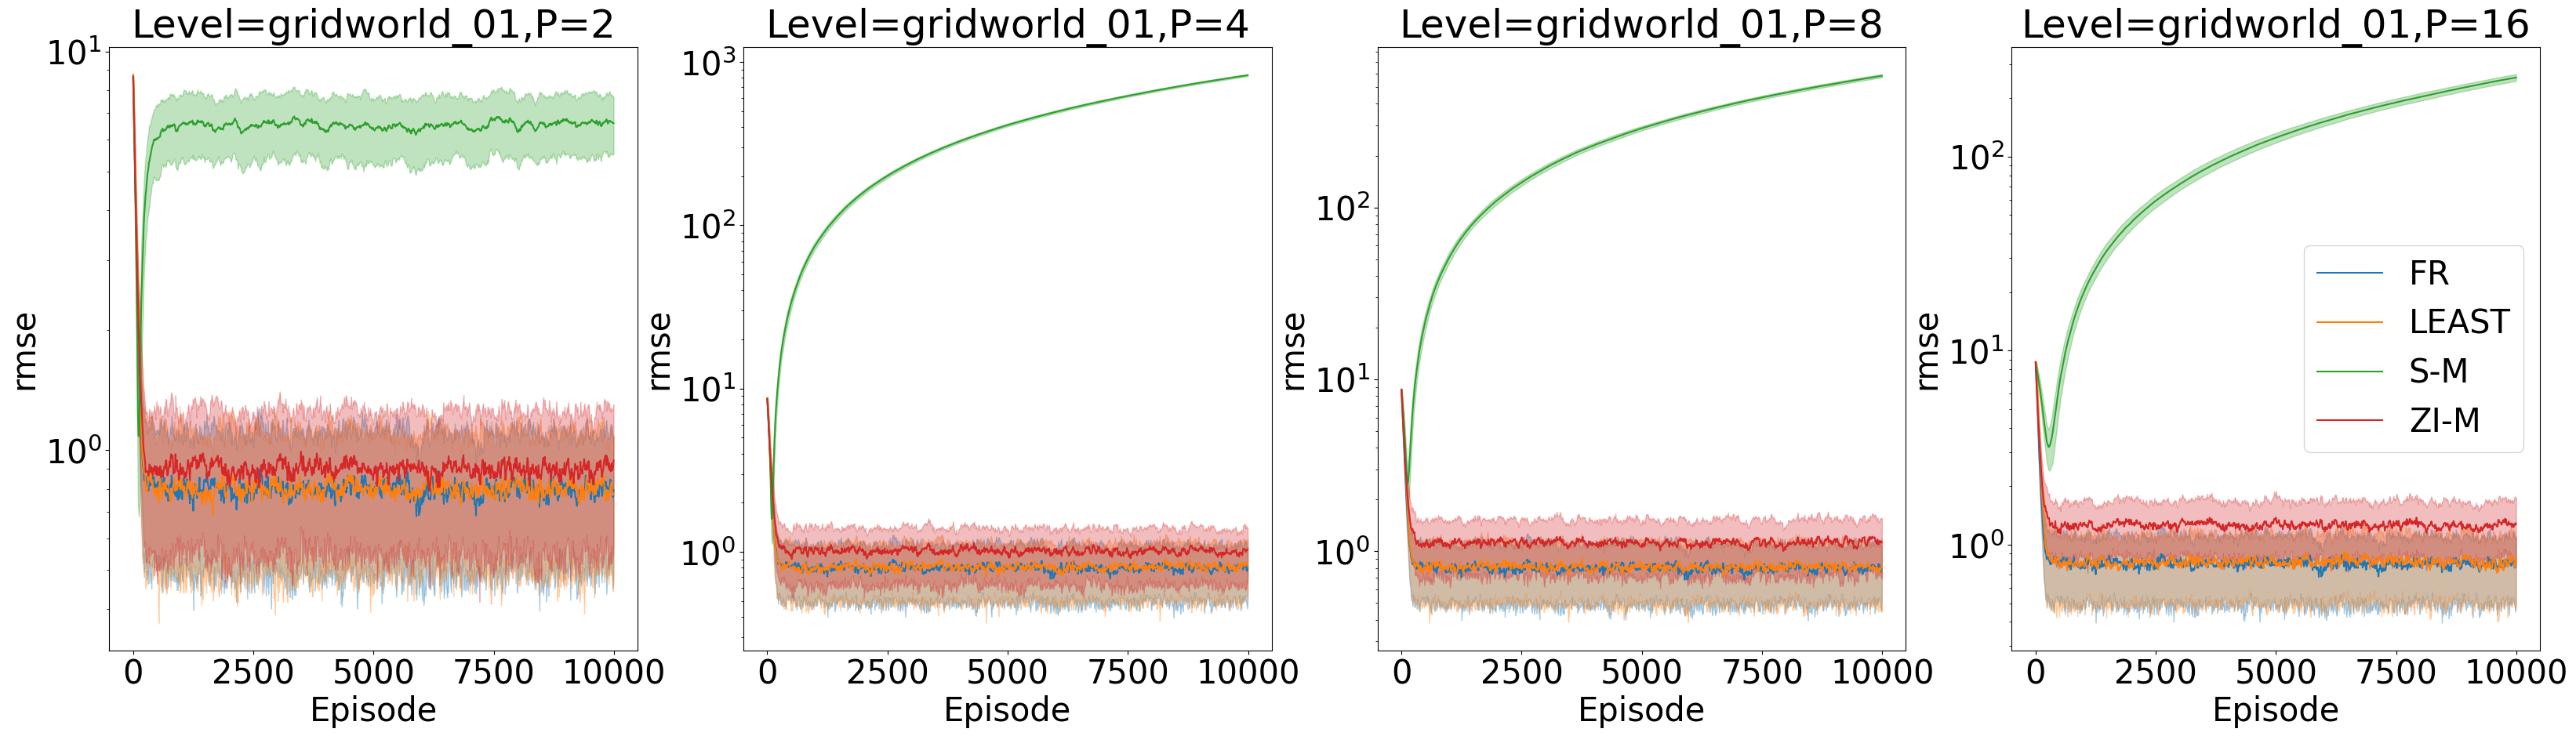

In [27]:
ax = utils.plot_multiple_configs(
    df_final,
    configs=[
        "Lgridworld_01-P2",
        "Lgridworld_01-P4",
        "Lgridworld_01-P8",
        "Lgridworld_01-P16",
    ],
    nrows=1,
    ncols=4,
    figsize=PLOT_SIZE,
    log_scale_y=True,
)
utils.export_figure(
    ax,
    "figures/cpr_v2/gridworld/gridworld_fixed_Lgridworld_01_change_Pxx",
    format="pdf",
)

In [28]:
utils.combine_table_config_comparisons(
    df_final,
    configs=[
        "Lgridworld_01-P2",
        "Lgridworld_01-P4",
        "Lgridworld_01-P8",
        "Lgridworld_01-P16",
    ],
)

config method  episode      rmse ± std rmse (mean) rmse (std)
999    Lgridworld_01-P2     FR     9990     0.794±0.289       0.794      0.289
2997   Lgridworld_01-P2  LEAST     9990     0.779±0.308       0.779      0.308
2999   Lgridworld_01-P2    S-M     9990     6.611±1.098       6.611      1.098
2998   Lgridworld_01-P2   ZI-M     9990      0.942±0.36       0.942       0.36
999    Lgridworld_01-P4     FR     9990     0.794±0.289       0.794      0.289
2999   Lgridworld_01-P4  LEAST     9990     0.862±0.327       0.862      0.327
2997   Lgridworld_01-P4    S-M     9990  829.452±11.684     829.452     11.684
2998   Lgridworld_01-P4   ZI-M     9990     1.033±0.342       1.033      0.342
999    Lgridworld_01-P8     FR     9990     0.794±0.289       0.794      0.289
2999   Lgridworld_01-P8  LEAST     9990      0.804±0.36       0.804       0.36
2998   Lgridworld_01-P8    S-M     9990  582.113±12.295     582.113     12.295
2997   Lgridworld_01-P8   ZI-M     9990     1.134±0.437       1.134      0.437
999   Lgridworld_01-P16     FR     9990     0.794±0.289       0.794      0.289
2998  Lgridworld_01-P16  LEAST     9990       0.8±0.311         0.8      0.311
2997  Lgridworld_01-P16    S-M     9990  255.516±10.338     255.516     10.338
2999  Lgridworld_01-P16   ZI-M     9990     1.273±0.454       1.273      0.454

### GridWorld 02


In [29]:
print(GRIDS["gridworld_02"])

sooooooooog


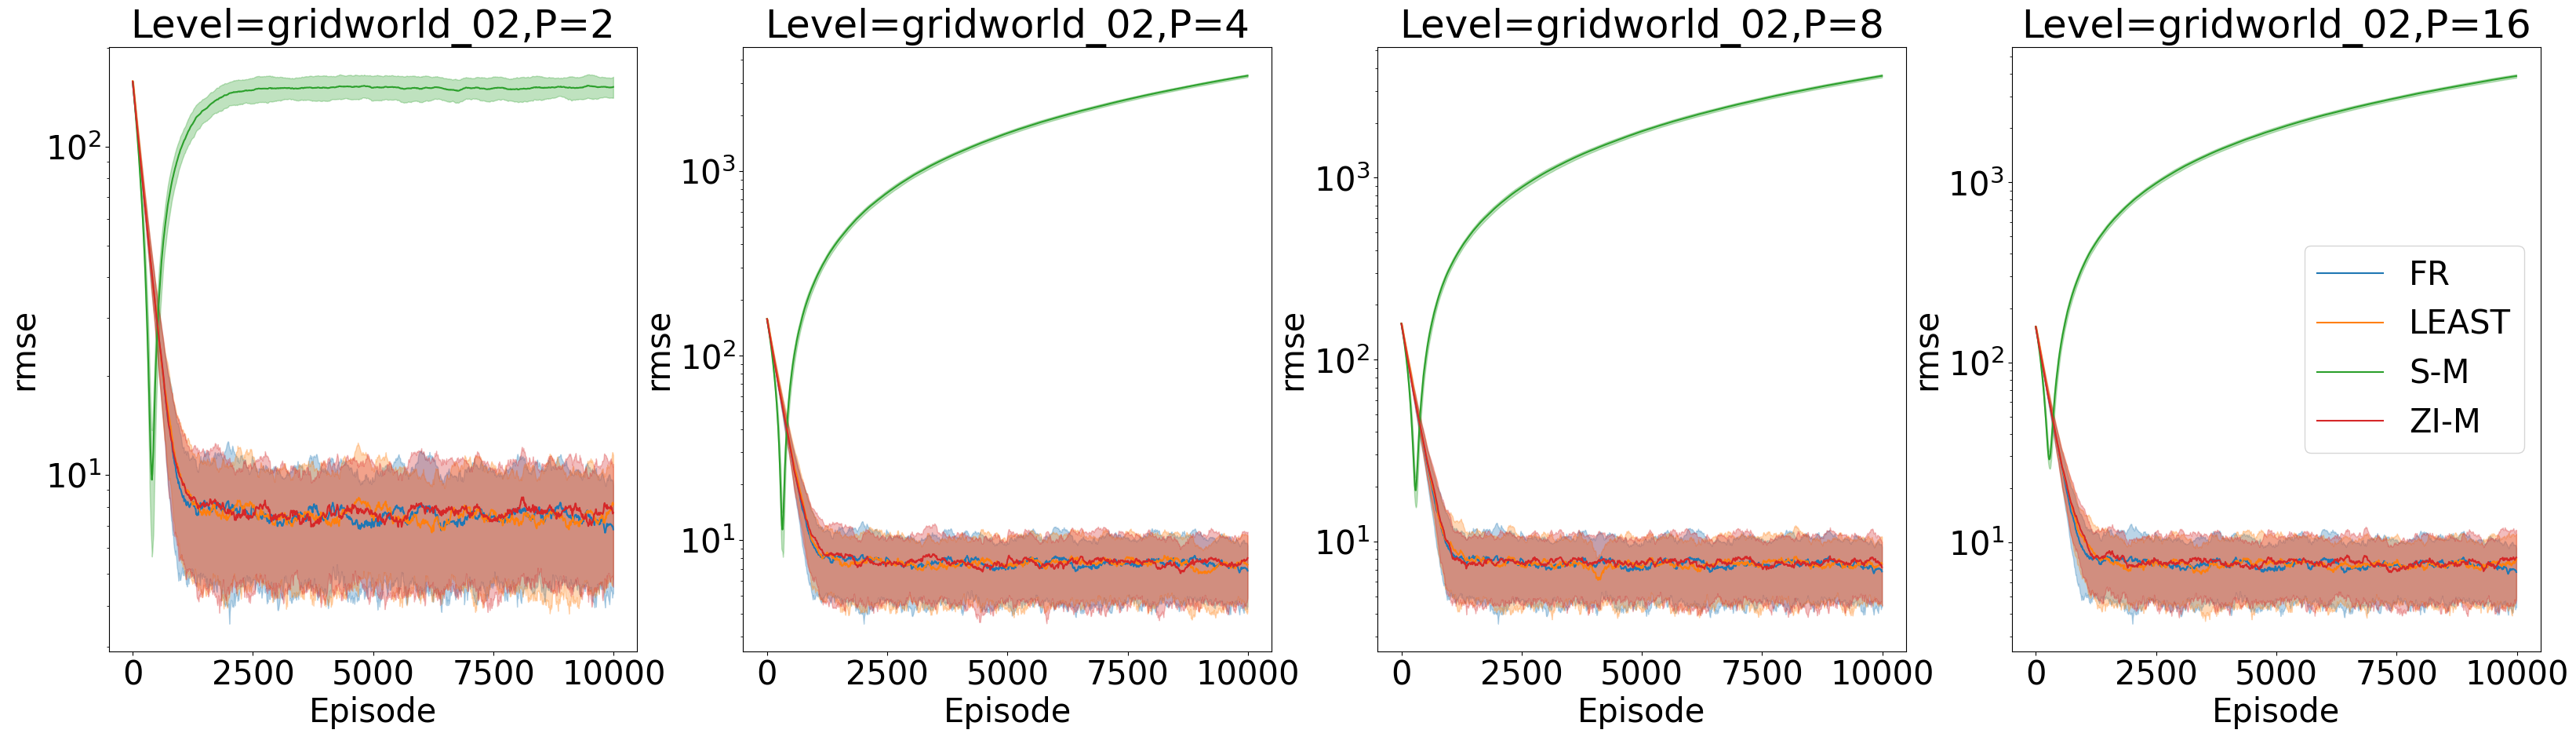

In [30]:
ax = utils.plot_multiple_configs(
    df_final,
    configs=[
        "Lgridworld_02-P2",
        "Lgridworld_02-P4",
        "Lgridworld_02-P8",
        "Lgridworld_02-P16",
    ],
    nrows=1,
    ncols=4,
    figsize=PLOT_SIZE,
    log_scale_y=True,
)
utils.export_figure(
    ax,
    "figures/cpr_v2/gridworld/gridworld_fixed_Lgridworld_02_change_Pxx",
    format="pdf",
)

In [31]:
utils.combine_table_config_comparisons(
    df_final,
    configs=[
        "Lgridworld_02-P2",
        "Lgridworld_02-P4",
        "Lgridworld_02-P8",
        "Lgridworld_02-P16",
    ],
)

config method  episode       rmse ± std rmse (mean)  \
999    Lgridworld_02-P2     FR     9990      6.826±2.471       6.826   
2998   Lgridworld_02-P2  LEAST     9990      8.143±3.325       8.143   
2997   Lgridworld_02-P2    S-M     9990   151.746±11.192     151.746   
2999   Lgridworld_02-P2   ZI-M     9990       7.68±3.116        7.68   
999    Lgridworld_02-P4     FR     9990      6.826±2.471       6.826   
2997   Lgridworld_02-P4  LEAST     9990      7.366±3.248       7.366   
2999   Lgridworld_02-P4    S-M     9990  3278.365±57.096    3278.365   
2998   Lgridworld_02-P4   ZI-M     9990      7.999±3.106       7.999   
999    Lgridworld_02-P8     FR     9990      6.826±2.471       6.826   
2997   Lgridworld_02-P8  LEAST     9990      7.519±3.097       7.519   
2999   Lgridworld_02-P8    S-M     9990  3631.848±70.689    3631.848   
2998   Lgridworld_02-P8   ZI-M     9990      7.205±2.769       7.205   
999   Lgridworld_02-P16     FR     9990      6.826±2.471       6.826   
2997  Lgridworld_02-P16  LEAST     9990      8.054±3.105       8.054   
2999  Lgridworld_02-P16    S-M     9990  3892.926±85.311    3892.926   
2998  Lgridworld_02-P16   ZI-M     9990      8.232±3.475       8.232   

     rmse (std)  
999       2.471  
2998      3.325  
2997     11.192  
2999      3.116  
999       2.471  
2997      3.248  
2999     57.096  
2998      3.106  
999       2.471  
2997      3.097  
2999     70.689  
2998      2.769  
999       2.471  
2997      3.105  
2999     85.311  
2998      3.475

### GridWorld 03


In [32]:
print(GRIDS["gridworld_03"])

ooooooooooo
ooooooooooo
sooooooooog


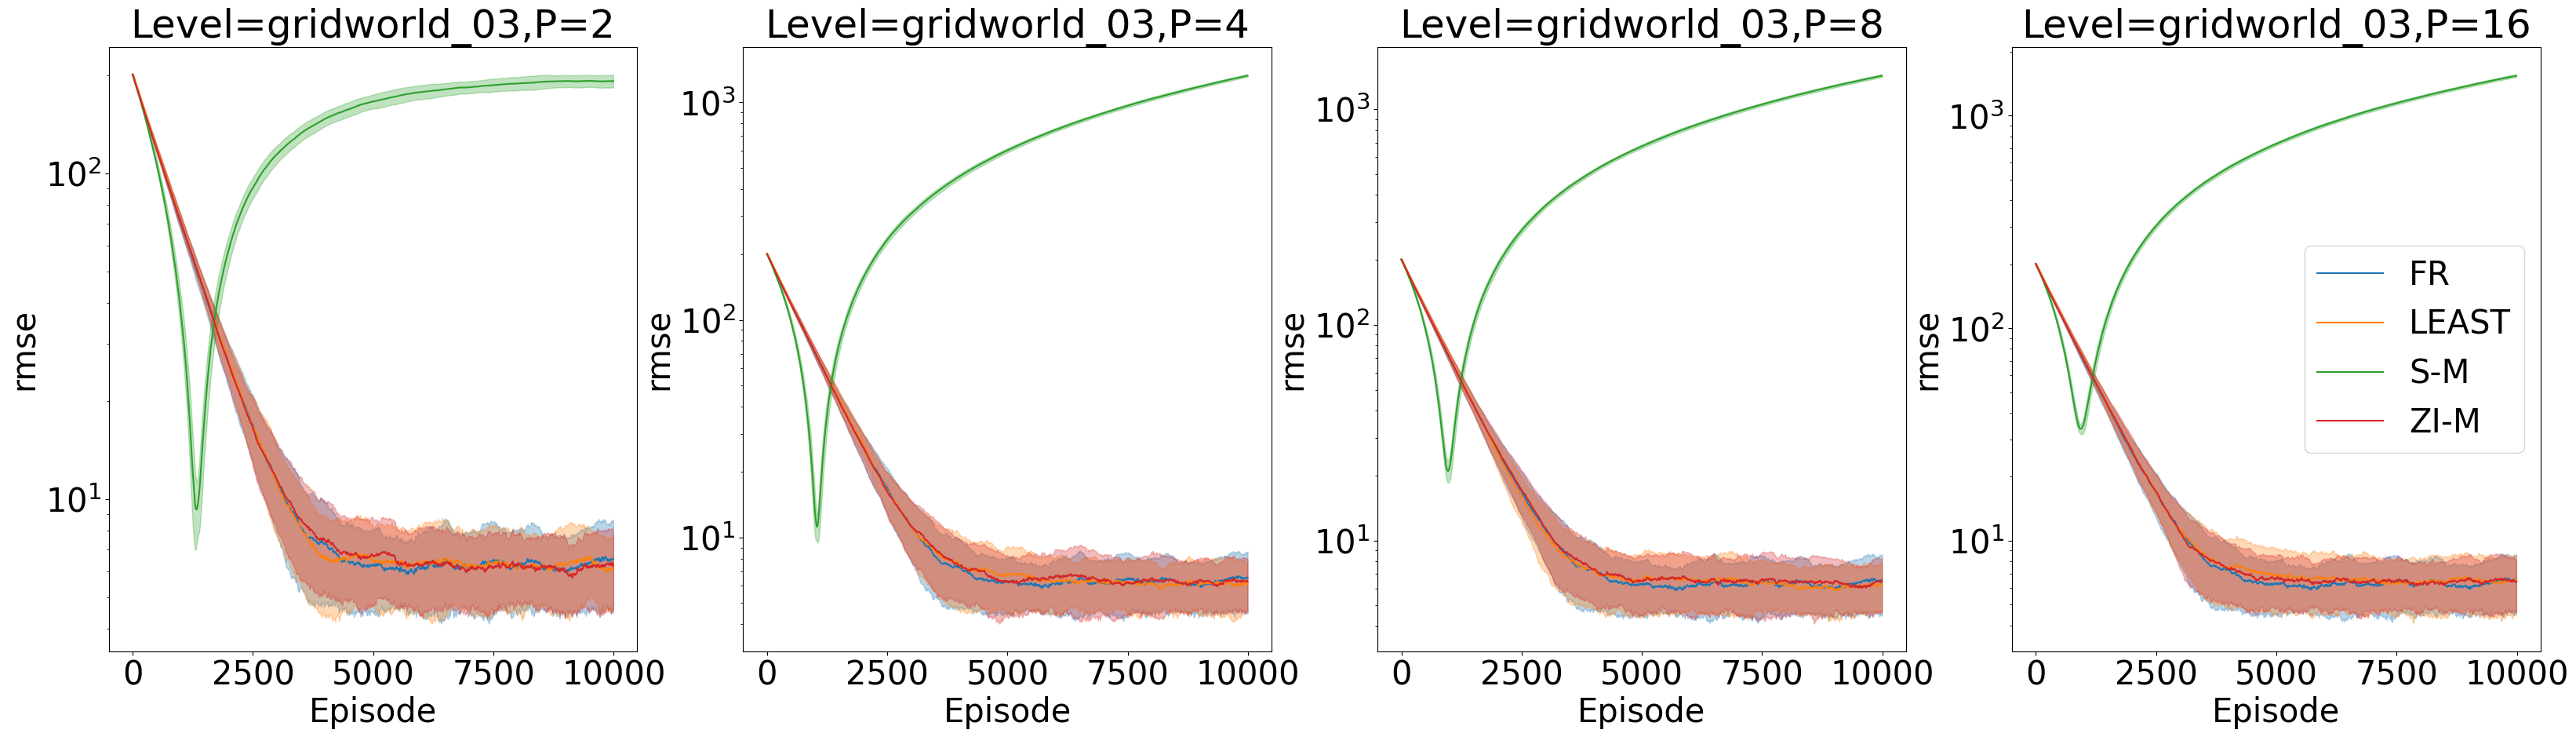

In [33]:
ax = utils.plot_multiple_configs(
    df_final,
    configs=[
        "Lgridworld_03-P2",
        "Lgridworld_03-P4",
        "Lgridworld_03-P8",
        "Lgridworld_03-P16",
    ],
    nrows=1,
    ncols=4,
    figsize=PLOT_SIZE,
    log_scale_y=True,
)
utils.export_figure(
    ax,
    "figures/cpr_v2/gridworld/gridworld_fixed_Lgridworld_03_change_Pxx",
    format="pdf",
)

In [34]:
utils.combine_table_config_comparisons(
    df_final,
    configs=[
        "Lgridworld_03-P2",
        "Lgridworld_03-P4",
        "Lgridworld_03-P8",
        "Lgridworld_03-P16",
    ],
)

config method  episode       rmse ± std rmse (mean)  \
999    Lgridworld_03-P2     FR     9990      6.558±2.079       6.558   
2998   Lgridworld_03-P2  LEAST     9990      6.127±1.569       6.127   
2997   Lgridworld_03-P2    S-M     9990    191.787±8.722     191.787   
2999   Lgridworld_03-P2   ZI-M     9990      6.235±1.675       6.235   
999    Lgridworld_03-P4     FR     9990      6.558±2.079       6.558   
2999   Lgridworld_03-P4  LEAST     9990       6.11±1.462        6.11   
2998   Lgridworld_03-P4    S-M     9990  1325.788±17.414    1325.788   
2997   Lgridworld_03-P4   ZI-M     9990       6.29±1.716        6.29   
999    Lgridworld_03-P8     FR     9990      6.558±2.079       6.558   
2999   Lgridworld_03-P8  LEAST     9990      6.261±1.613       6.261   
2997   Lgridworld_03-P8    S-M     9990  1426.788±21.406    1426.788   
2998   Lgridworld_03-P8   ZI-M     9990      6.524±1.777       6.524   
999   Lgridworld_03-P16     FR     9990      6.558±2.079       6.558   
2999  Lgridworld_03-P16  LEAST     9990      6.498±1.904       6.498   
2998  Lgridworld_03-P16    S-M     9990  1541.833±23.052    1541.833   
2997  Lgridworld_03-P16   ZI-M     9990       6.389±1.76       6.389   

     rmse (std)  
999       2.079  
2998      1.569  
2997      8.722  
2999      1.675  
999       2.079  
2999      1.462  
2998     17.414  
2997      1.716  
999       2.079  
2999      1.613  
2997     21.406  
2998      1.777  
999       2.079  
2999      1.904  
2998     23.052  
2997       1.76

### GridWorld 04

In [35]:
print(GRIDS["gridworld_04"])

oooooooooog
ooooooooooo
soooooooooo


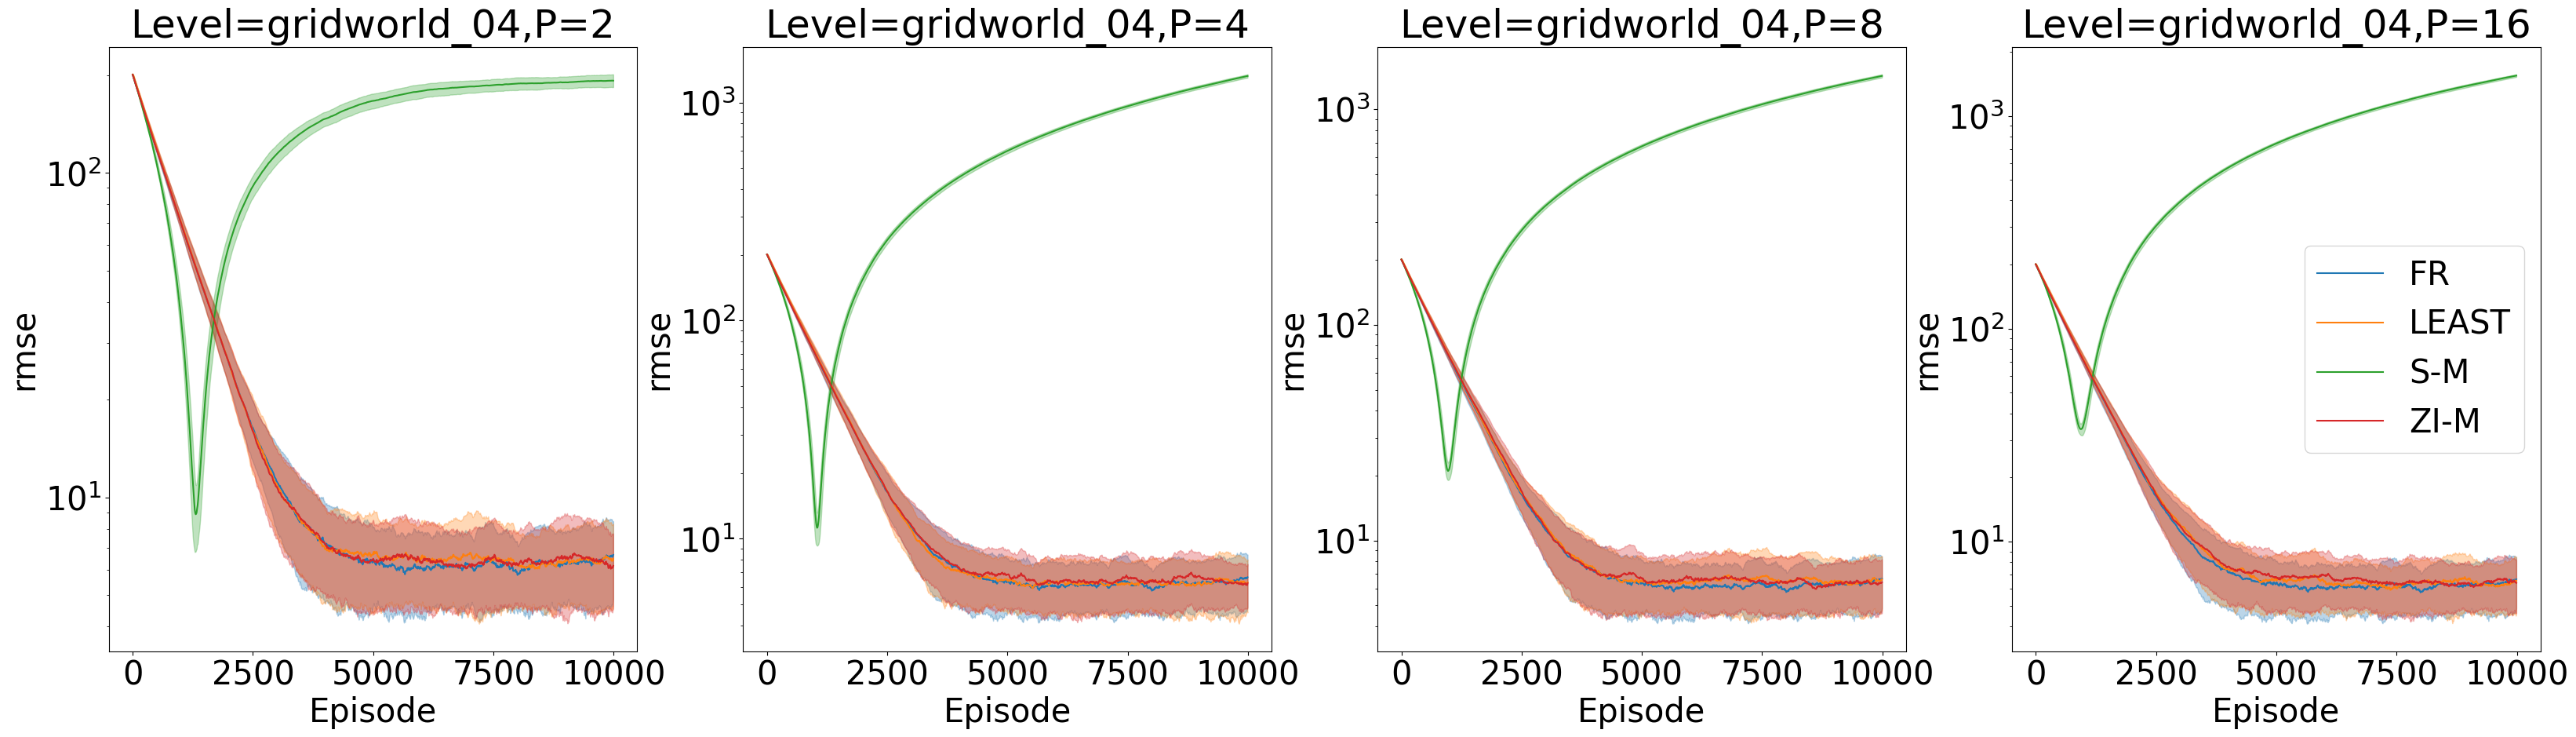

In [36]:
ax = utils.plot_multiple_configs(
    df_final,
    configs=[
        "Lgridworld_04-P2",
        "Lgridworld_04-P4",
        "Lgridworld_04-P8",
        "Lgridworld_04-P16",
    ],
    nrows=1,
    ncols=4,
    figsize=PLOT_SIZE,
    log_scale_y=True,
)
utils.export_figure(
    ax,
    "figures/cpr_v2/gridworld/gridworld_fixed_Lgridworld_04_change_Pxx",
    format="pdf",
)

In [37]:
utils.combine_table_config_comparisons(
    df_final,
    configs=[
        "Lgridworld_04-P2",
        "Lgridworld_04-P4",
        "Lgridworld_04-P8",
        "Lgridworld_04-P16",
    ],
)

config method  episode       rmse ± std rmse (mean)  \
999    Lgridworld_04-P2     FR     9990      6.655±1.795       6.655   
2999   Lgridworld_04-P2  LEAST     9990      6.467±1.838       6.467   
2998   Lgridworld_04-P2    S-M     9990    192.357±8.715     192.357   
2997   Lgridworld_04-P2   ZI-M     9990      6.159±1.593       6.159   
999    Lgridworld_04-P4     FR     9990      6.655±1.795       6.655   
2998   Lgridworld_04-P4  LEAST     9990      6.306±1.718       6.306   
2997   Lgridworld_04-P4    S-M     9990  1322.079±23.193    1322.079   
2999   Lgridworld_04-P4   ZI-M     9990      6.247±1.404       6.247   
999    Lgridworld_04-P8     FR     9990      6.655±1.795       6.655   
2997   Lgridworld_04-P8  LEAST     9990      6.596±1.864       6.596   
2999   Lgridworld_04-P8    S-M     9990  1424.107±24.225    1424.107   
2998   Lgridworld_04-P8   ZI-M     9990      6.397±1.784       6.397   
999   Lgridworld_04-P16     FR     9990      6.655±1.795       6.655   
2998  Lgridworld_04-P16  LEAST     9990      6.553±1.962       6.553   
2997  Lgridworld_04-P16    S-M     9990  1544.188±21.589    1544.188   
2999  Lgridworld_04-P16   ZI-M     9990       6.399±1.78       6.399   

     rmse (std)  
999       1.795  
2999      1.838  
2998      8.715  
2997      1.593  
999       1.795  
2998      1.718  
2997     23.193  
2999      1.404  
999       1.795  
2997      1.864  
2999     24.225  
2998      1.784  
999       1.795  
2998      1.962  
2997     21.589  
2999       1.78

### GridWorld Cliff 01

In [38]:
print(GRIDS["gridworld_cliff_01"])

xsog


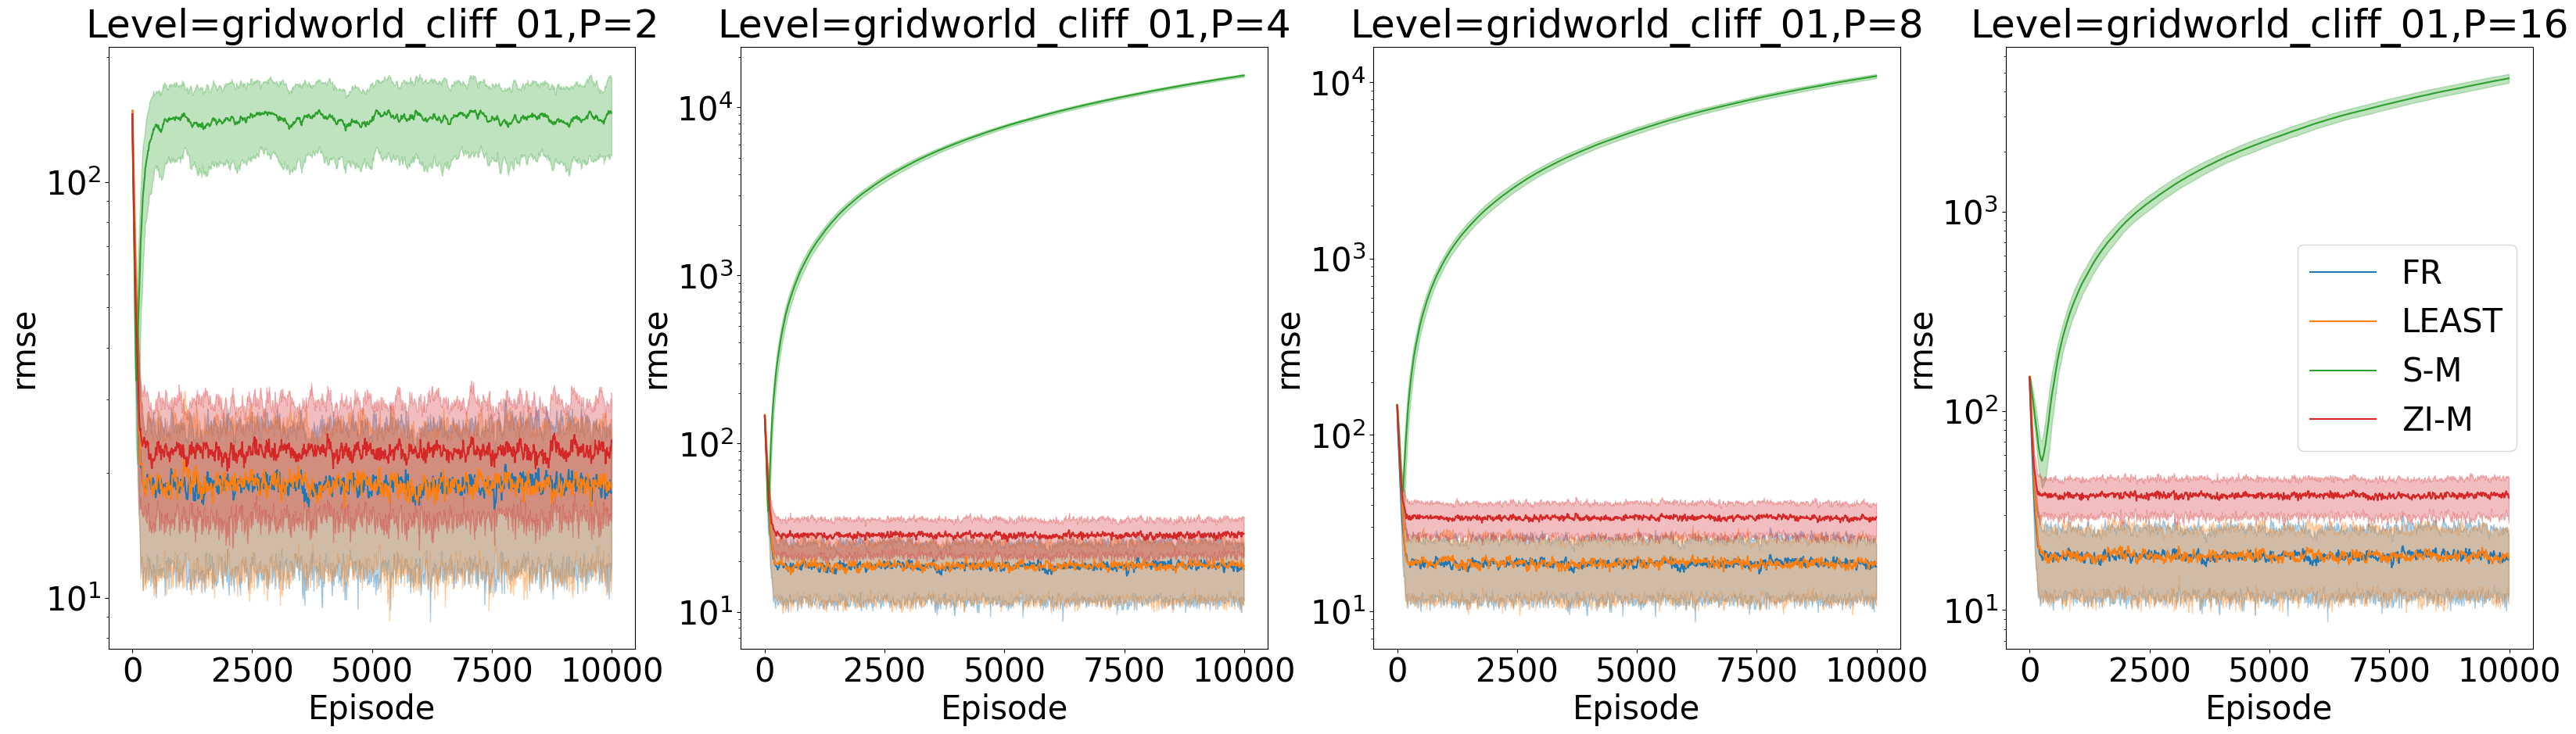

In [39]:
ax = utils.plot_multiple_configs(
    df_final,
    configs=[
        "Lgridworld_cliff_01-P2",
        "Lgridworld_cliff_01-P4",
        "Lgridworld_cliff_01-P8",
        "Lgridworld_cliff_01-P16",
    ],
    nrows=1,
    ncols=4,
    figsize=PLOT_SIZE,
    log_scale_y=True,
)
utils.export_figure(
    ax,
    "figures/cpr_v2/gridworld_cliff/gridworld_fixed_Lgridworld_cliff_01_change_Pxx",
    format="pdf",
)

In [40]:
utils.combine_table_config_comparisons(
    df_final,
    configs=[
        "Lgridworld_cliff_01-P2",
        "Lgridworld_cliff_01-P4",
        "Lgridworld_cliff_01-P8",
        "Lgridworld_cliff_01-P16",
    ],
)

config method  episode         rmse ± std rmse (mean)  \
999    Lgridworld_cliff_01-P2     FR     9990       17.951±6.268      17.951   
2998   Lgridworld_cliff_01-P2  LEAST     9990       18.358±7.056      18.358   
2997   Lgridworld_cliff_01-P2    S-M     9990      146.72±30.606      146.72   
2999   Lgridworld_cliff_01-P2   ZI-M     9990       23.908±7.277      23.908   
999    Lgridworld_cliff_01-P4     FR     9990       17.951±6.268      17.951   
2999   Lgridworld_cliff_01-P4  LEAST     9990       18.786±7.001      18.786   
2998   Lgridworld_cliff_01-P4    S-M     9990  15464.607±301.918   15464.607   
2997   Lgridworld_cliff_01-P4   ZI-M     9990       29.085±7.457      29.085   
999    Lgridworld_cliff_01-P8     FR     9990       17.951±6.268      17.951   
2997   Lgridworld_cliff_01-P8  LEAST     9990       18.786±8.061      18.786   
2999   Lgridworld_cliff_01-P8    S-M     9990   10844.884±297.05   10844.884   
2998   Lgridworld_cliff_01-P8   ZI-M     9990       34.247±7.233      34.247   
999   Lgridworld_cliff_01-P16     FR     9990       17.951±6.268      17.951   
2997  Lgridworld_cliff_01-P16  LEAST     9990       18.107±7.386      18.107   
2999  Lgridworld_cliff_01-P16    S-M     9990   4669.388±237.253    4669.388   
2998  Lgridworld_cliff_01-P16   ZI-M     9990        36.61±9.242       36.61   

     rmse (std)  
999       6.268  
2998      7.056  
2997     30.606  
2999      7.277  
999       6.268  
2999      7.001  
2998    301.918  
2997      7.457  
999       6.268  
2997      8.061  
2999     297.05  
2998      7.233  
999       6.268  
2997      7.386  
2999    237.253  
2998      9.242

### GridWorld Cliff 02

In [41]:
print(GRIDS["gridworld_cliff_02"])

oooxoooo
soooooog


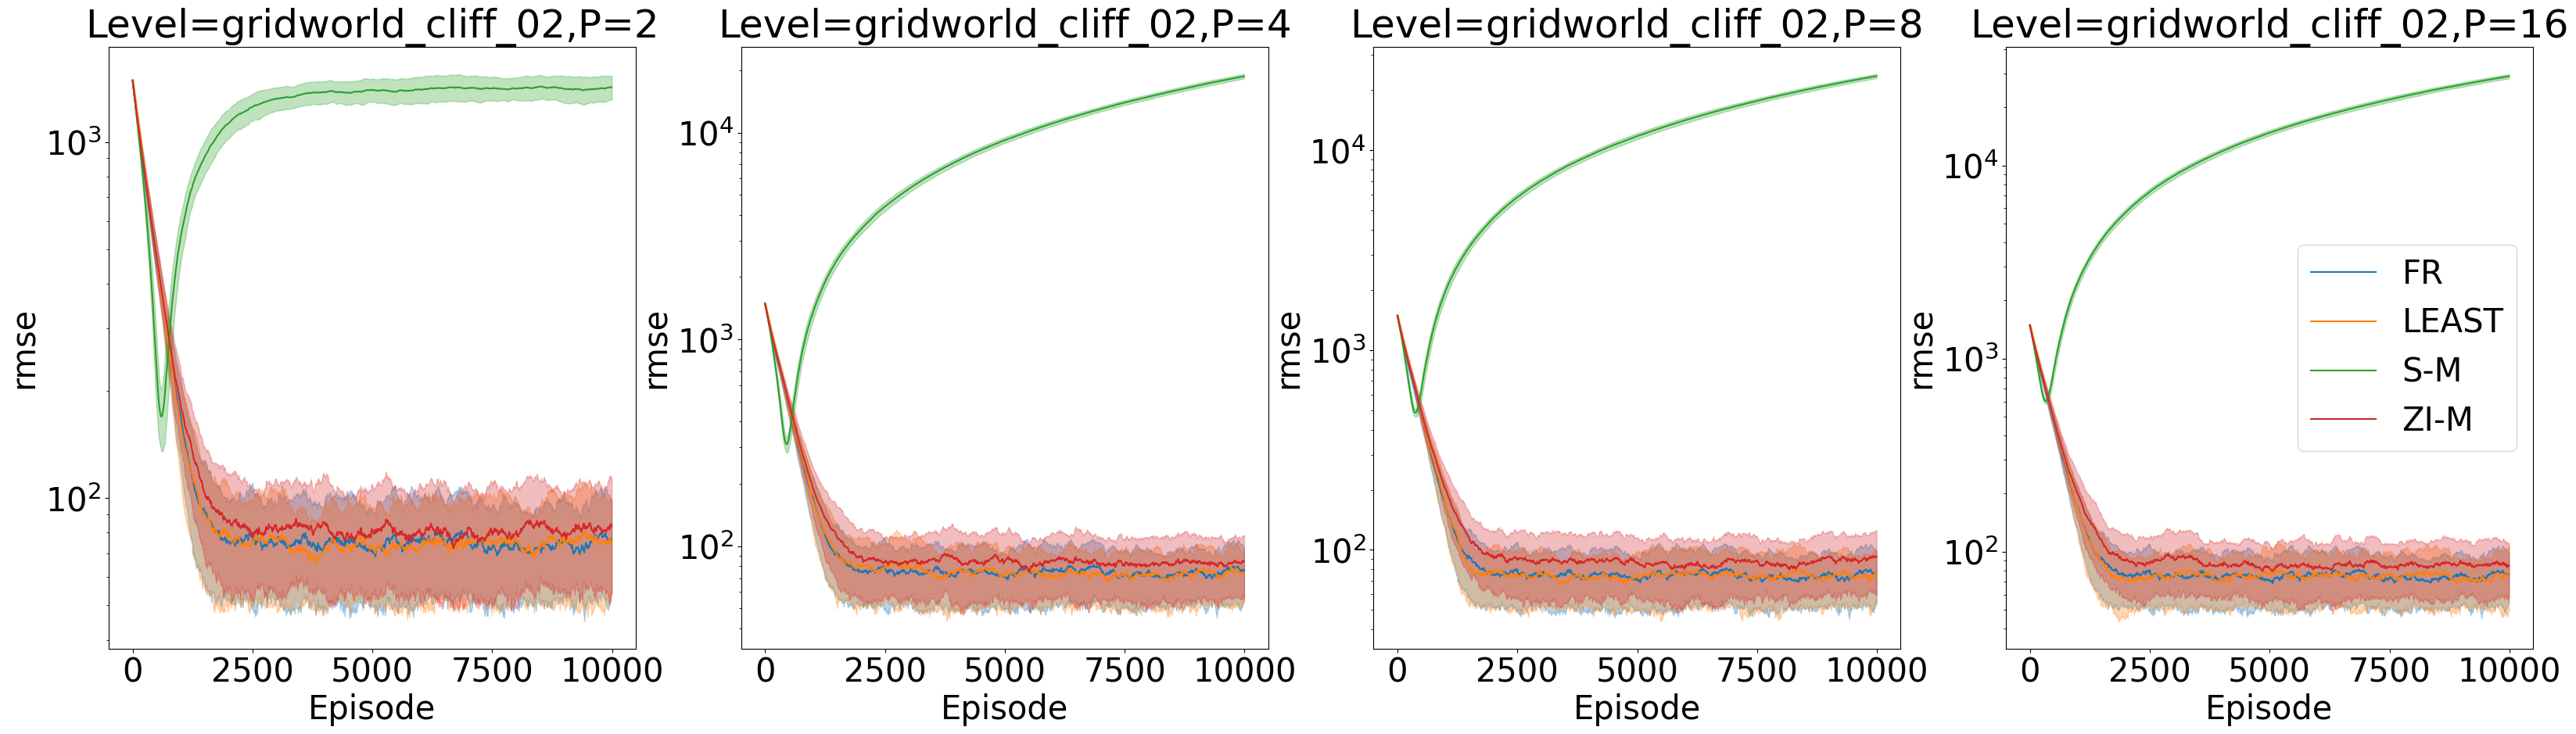

In [42]:
ax = utils.plot_multiple_configs(
    df_final,
    configs=[
        "Lgridworld_cliff_02-P2",
        "Lgridworld_cliff_02-P4",
        "Lgridworld_cliff_02-P8",
        "Lgridworld_cliff_02-P16",
    ],
    nrows=1,
    ncols=4,
    figsize=PLOT_SIZE,
    log_scale_y=True,
)
utils.export_figure(
    ax,
    "figures/cpr_v2/gridworld_cliff/gridworld_fixed_Lgridworld_cliff_02_change_Pxx",
    format="pdf",
)

In [43]:
utils.combine_table_config_comparisons(
    df_final,
    configs=[
        "Lgridworld_cliff_02-P2",
        "Lgridworld_cliff_02-P4",
        "Lgridworld_cliff_02-P8",
        "Lgridworld_cliff_02-P16",
    ],
)

config method  episode         rmse ± std rmse (mean)  \
999    Lgridworld_cliff_02-P2     FR     9990      76.207±21.883      76.207   
2998   Lgridworld_cliff_02-P2  LEAST     9990      76.366±23.349      76.366   
2997   Lgridworld_cliff_02-P2    S-M     9990   1422.375±112.609    1422.375   
2999   Lgridworld_cliff_02-P2   ZI-M     9990      83.367±29.428      83.367   
999    Lgridworld_cliff_02-P4     FR     9990      76.207±21.883      76.207   
2999   Lgridworld_cliff_02-P4  LEAST     9990       73.57±20.862       73.57   
2997   Lgridworld_cliff_02-P4    S-M     9990   18701.14±472.262    18701.14   
2998   Lgridworld_cliff_02-P4   ZI-M     9990       84.27±27.786       84.27   
999    Lgridworld_cliff_02-P8     FR     9990      76.207±21.883      76.207   
2999   Lgridworld_cliff_02-P8  LEAST     9990      76.301±22.312      76.301   
2998   Lgridworld_cliff_02-P8    S-M     9990  23526.073±552.762   23526.073   
2997   Lgridworld_cliff_02-P8   ZI-M     9990      92.333±32.612      92.333   
999   Lgridworld_cliff_02-P16     FR     9990      76.207±21.883      76.207   
2998  Lgridworld_cliff_02-P16  LEAST     9990       78.06±29.346       78.06   
2997  Lgridworld_cliff_02-P16    S-M     9990  28970.506±776.073   28970.506   
2999  Lgridworld_cliff_02-P16   ZI-M     9990      84.322±26.027      84.322   

     rmse (std)  
999      21.883  
2998     23.349  
2997    112.609  
2999     29.428  
999      21.883  
2999     20.862  
2997    472.262  
2998     27.786  
999      21.883  
2999     22.312  
2998    552.762  
2997     32.612  
999      21.883  
2998     29.346  
2997    776.073  
2999     26.027

### GridWorld Cliff 03

In [44]:
print(GRIDS["gridworld_cliff_03"])

oooooooo
ooxoooog
sooooxoo


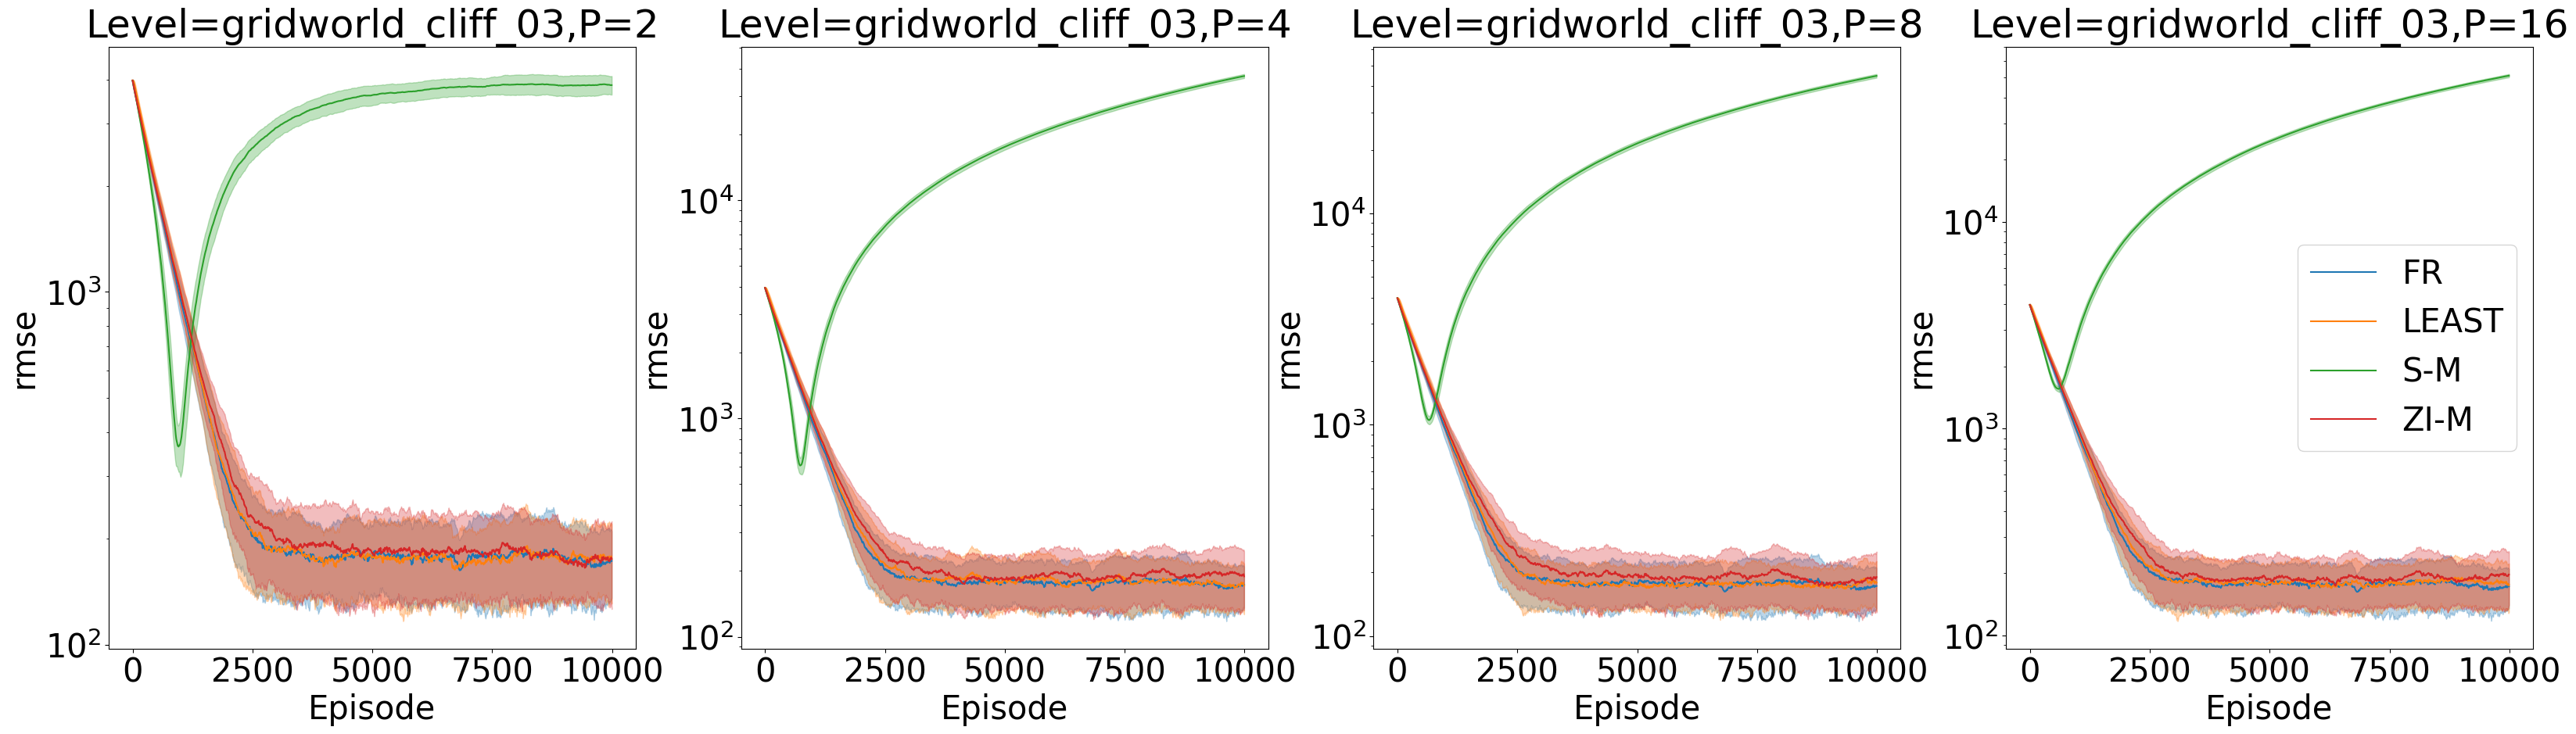

In [45]:
ax = utils.plot_multiple_configs(
    df_final,
    configs=[
        "Lgridworld_cliff_03-P2",
        "Lgridworld_cliff_03-P4",
        "Lgridworld_cliff_03-P8",
        "Lgridworld_cliff_03-P16",
    ],
    nrows=1,
    ncols=4,
    figsize=PLOT_SIZE,
    log_scale_y=True,
)
utils.export_figure(
    ax,
    "figures/cpr_v2/gridworld_cliff/gridworld_fixed_Lgridworld_cliff_03_change_Pxx",
    format="pdf",
)

In [46]:
utils.combine_table_config_comparisons(
    df_final,
    configs=[
        "Lgridworld_cliff_03-P2",
        "Lgridworld_cliff_03-P4",
        "Lgridworld_cliff_03-P8",
        "Lgridworld_cliff_03-P16",
    ],
)

config method  episode         rmse ± std rmse (mean)  \
999    Lgridworld_cliff_03-P2     FR     9990     172.776±36.944     172.776   
2999   Lgridworld_cliff_03-P2  LEAST     9990     175.352±44.501     175.352   
2997   Lgridworld_cliff_03-P2    S-M     9990   3855.196±232.795    3855.196   
2998   Lgridworld_cliff_03-P2   ZI-M     9990     175.059±48.792     175.059   
999    Lgridworld_cliff_03-P4     FR     9990     172.776±36.944     172.776   
2999   Lgridworld_cliff_03-P4  LEAST     9990     171.555±45.002     171.555   
2998   Lgridworld_cliff_03-P4    S-M     9990  37117.598±799.424   37117.598   
2997   Lgridworld_cliff_03-P4   ZI-M     9990     189.062±57.047     189.062   
999    Lgridworld_cliff_03-P8     FR     9990     172.776±36.944     172.776   
2997   Lgridworld_cliff_03-P8  LEAST     9990     179.191±47.688     179.191   
2999   Lgridworld_cliff_03-P8    S-M     9990   44724.537±890.64   44724.537   
2998   Lgridworld_cliff_03-P8   ZI-M     9990      190.38±60.922      190.38   
999   Lgridworld_cliff_03-P16     FR     9990     172.776±36.944     172.776   
2997  Lgridworld_cliff_03-P16  LEAST     9990     176.573±46.482     176.573   
2998  Lgridworld_cliff_03-P16    S-M     9990  51003.109±921.199   51003.109   
2999  Lgridworld_cliff_03-P16   ZI-M     9990     197.205±56.513     197.205   

     rmse (std)  
999      36.944  
2999     44.501  
2997    232.795  
2998     48.792  
999      36.944  
2999     45.002  
2998    799.424  
2997     57.047  
999      36.944  
2997     47.688  
2999     890.64  
2998     60.922  
999      36.944  
2997     46.482  
2998    921.199  
2999     56.513

### GridWorld Cliff 04

In [47]:
print(GRIDS["gridworld_cliff_04"])

xxxxxxxx
oooooooo
soooooog


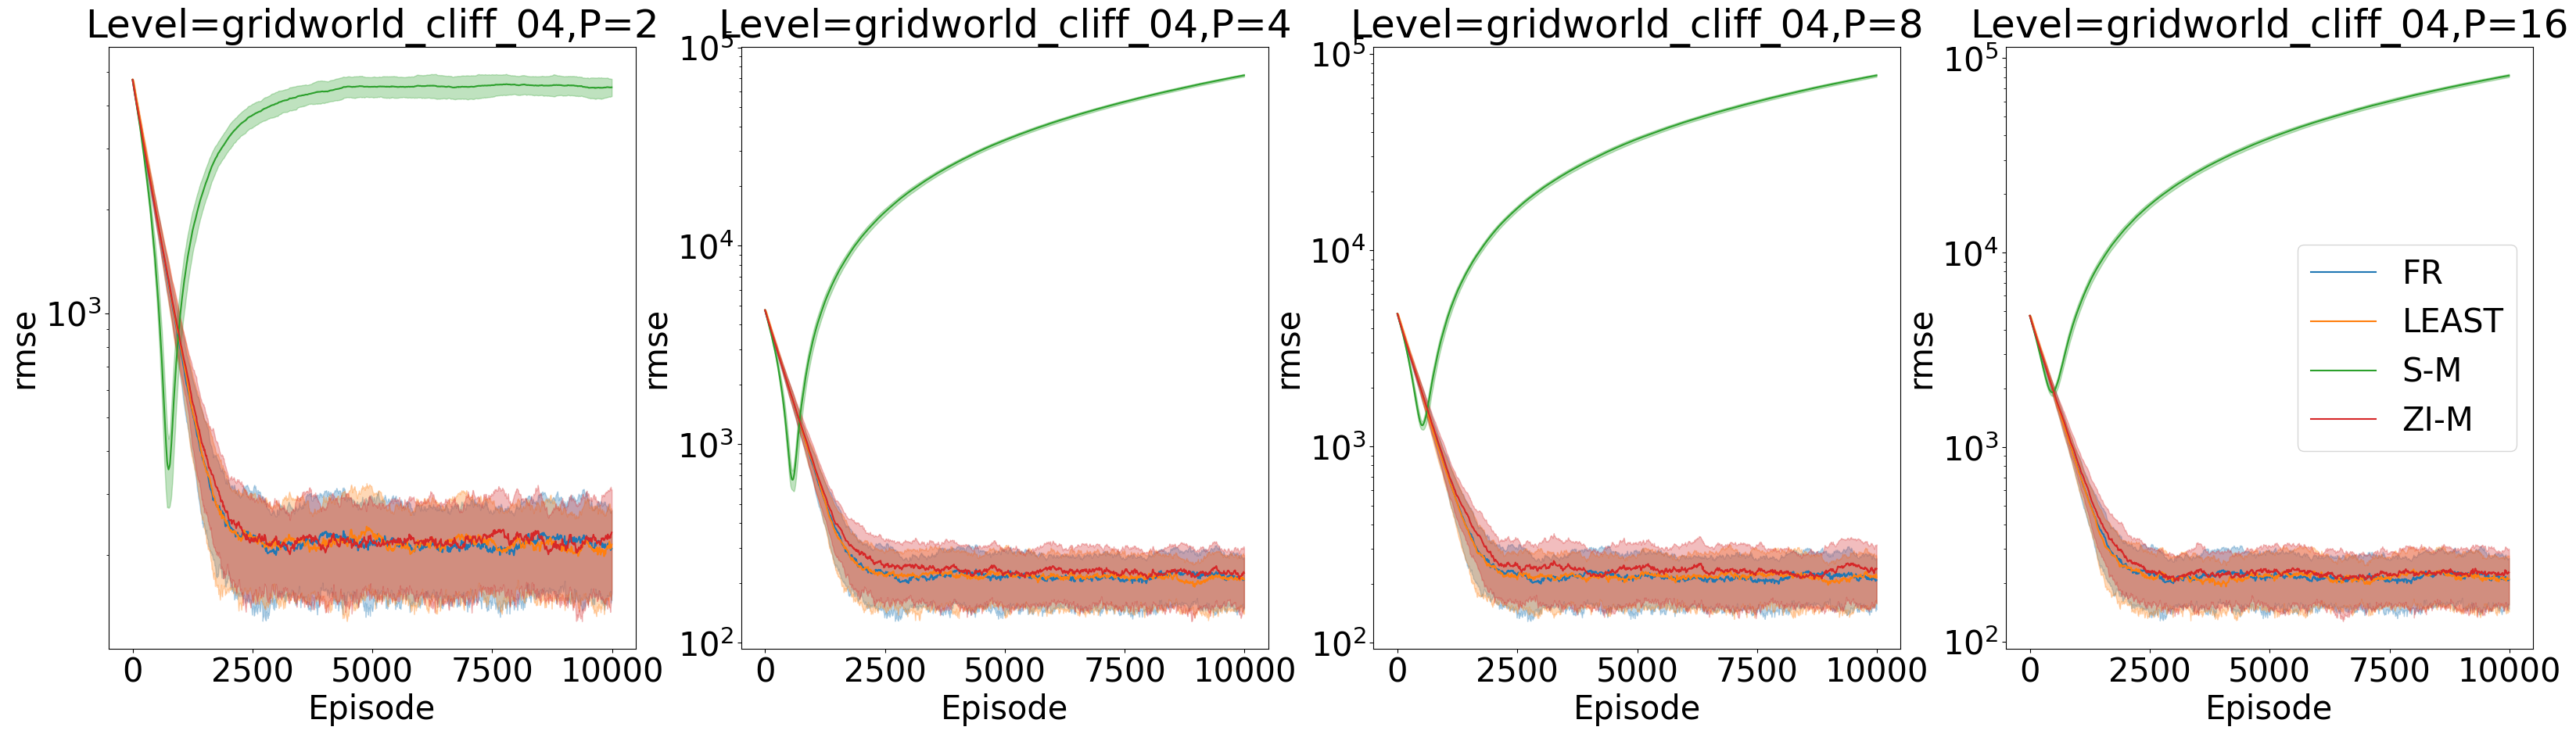

In [48]:
ax = utils.plot_multiple_configs(
    df_final,
    configs=[
        "Lgridworld_cliff_04-P2",
        "Lgridworld_cliff_04-P4",
        "Lgridworld_cliff_04-P8",
        "Lgridworld_cliff_04-P16",
    ],
    nrows=1,
    ncols=4,
    figsize=PLOT_SIZE,
    log_scale_y=True,
)
utils.export_figure(
    ax,
    "figures/cpr_v2/gridworld_cliff/gridworld_fixed_Lgridworld_cliff_04_change_Pxx",
    format="pdf",
)

In [49]:
utils.combine_table_config_comparisons(
    df_final,
    configs=[
        "Lgridworld_cliff_04-P2",
        "Lgridworld_cliff_04-P4",
        "Lgridworld_cliff_04-P8",
        "Lgridworld_cliff_04-P16",
    ],
)

config method  episode          rmse ± std rmse (mean)  \
999    Lgridworld_cliff_04-P2     FR     9990      208.273±60.757     208.273   
2997   Lgridworld_cliff_04-P2  LEAST     9990      214.049±55.311     214.049   
2998   Lgridworld_cliff_04-P2    S-M     9990    4507.072±259.136    4507.072   
2999   Lgridworld_cliff_04-P2   ZI-M     9990      231.896±77.136     231.896   
999    Lgridworld_cliff_04-P4     FR     9990      208.273±60.757     208.273   
2999   Lgridworld_cliff_04-P4  LEAST     9990      208.415±67.846     208.415   
2998   Lgridworld_cliff_04-P4    S-M     9990  72255.124±1089.877   72255.124   
2997   Lgridworld_cliff_04-P4   ZI-M     9990      224.557±73.985     224.557   
999    Lgridworld_cliff_04-P8     FR     9990      208.273±60.757     208.273   
2997   Lgridworld_cliff_04-P8  LEAST     9990      215.202±57.423     215.202   
2999   Lgridworld_cliff_04-P8    S-M     9990  77846.179±1261.022   77846.179   
2998   Lgridworld_cliff_04-P8   ZI-M     9990       238.17±78.738      238.17   
999   Lgridworld_cliff_04-P16     FR     9990      208.273±60.757     208.273   
2998  Lgridworld_cliff_04-P16  LEAST     9990      210.195±67.556     210.195   
2997  Lgridworld_cliff_04-P16    S-M     9990  81423.459±1497.639   81423.459   
2999  Lgridworld_cliff_04-P16   ZI-M     9990       227.03±72.066      227.03   

     rmse (std)  
999      60.757  
2997     55.311  
2998    259.136  
2999     77.136  
999      60.757  
2999     67.846  
2998   1089.877  
2997     73.985  
999      60.757  
2997     57.423  
2999   1261.022  
2998     78.738  
999      60.757  
2998     67.556  
2997   1497.639  
2999     72.066

### GridWorld Cliff 05

In [50]:
print(GRIDS["gridworld_cliff_05"])

oooooooo
oooooooo
sxxxxxxg


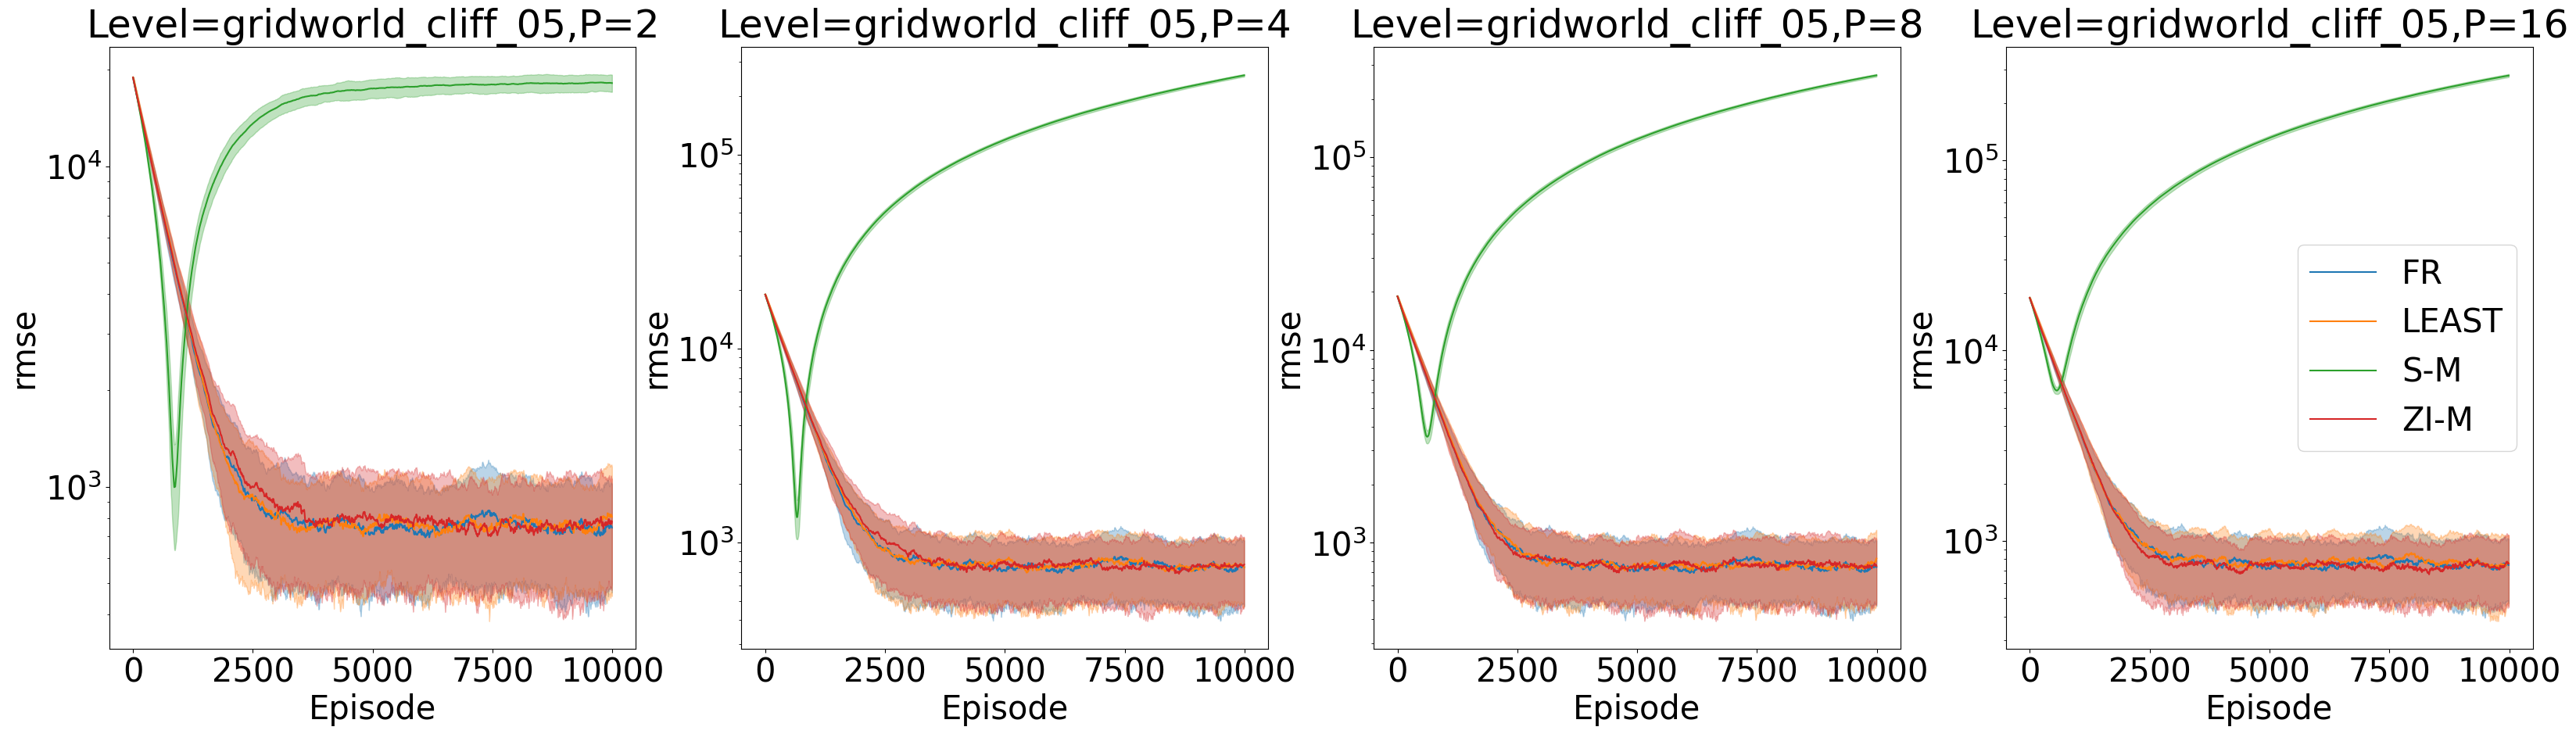

In [51]:
ax = utils.plot_multiple_configs(
    df_final,
    configs=[
        "Lgridworld_cliff_05-P2",
        "Lgridworld_cliff_05-P4",
        "Lgridworld_cliff_05-P8",
        "Lgridworld_cliff_05-P16",
    ],
    nrows=1,
    ncols=4,
    figsize=PLOT_SIZE,
    log_scale_y=True,
)
utils.export_figure(
    ax,
    "figures/cpr_v2/gridworld_cliff/gridworld_fixed_Lgridworld_cliff_05_change_Pxx",
    format="pdf",
)

In [52]:
utils.combine_table_config_comparisons(
    df_final,
    configs=[
        "Lgridworld_cliff_05-P2",
        "Lgridworld_cliff_05-P4",
        "Lgridworld_cliff_05-P8",
        "Lgridworld_cliff_05-P16",
    ],
)

config method  episode           rmse ± std  \
999    Lgridworld_cliff_05-P2     FR     9990       745.885±277.91   
2997   Lgridworld_cliff_05-P2  LEAST     9990      806.638±350.586   
2999   Lgridworld_cliff_05-P2    S-M     9990    18195.32±1118.722   
2998   Lgridworld_cliff_05-P2   ZI-M     9990       779.158±280.31   
999    Lgridworld_cliff_05-P4     FR     9990       745.885±277.91   
2997   Lgridworld_cliff_05-P4  LEAST     9990       739.775±272.95   
2998   Lgridworld_cliff_05-P4    S-M     9990  255804.832±3890.733   
2999   Lgridworld_cliff_05-P4   ZI-M     9990      768.801±287.025   
999    Lgridworld_cliff_05-P8     FR     9990       745.885±277.91   
2999   Lgridworld_cliff_05-P8  LEAST     9990      826.515±337.681   
2997   Lgridworld_cliff_05-P8    S-M     9990    265567.7±4103.359   
2998   Lgridworld_cliff_05-P8   ZI-M     9990       756.606±280.82   
999   Lgridworld_cliff_05-P16     FR     9990       745.885±277.91   
2998  Lgridworld_cliff_05-P16  LEAST     9990      762.568±308.587   
2997  Lgridworld_cliff_05-P16    S-M     9990  279066.206±5158.172   
2999  Lgridworld_cliff_05-P16   ZI-M     9990       759.32±312.452   

     rmse (mean) rmse (std)  
999      745.885     277.91  
2997     806.638    350.586  
2999    18195.32   1118.722  
2998     779.158     280.31  
999      745.885     277.91  
2997     739.775     272.95  
2998  255804.832   3890.733  
2999     768.801    287.025  
999      745.885     277.91  
2999     826.515    337.681  
2997    265567.7   4103.359  
2998     756.606     280.82  
999      745.885     277.91  
2998     762.568    308.587  
2997  279066.206   5158.172  
2999      759.32    312.452

### GridWorld Cliff 06

In [53]:
print(GRIDS["gridworld_cliff_06"])

oooooooo
oxoooooo
soxoooog


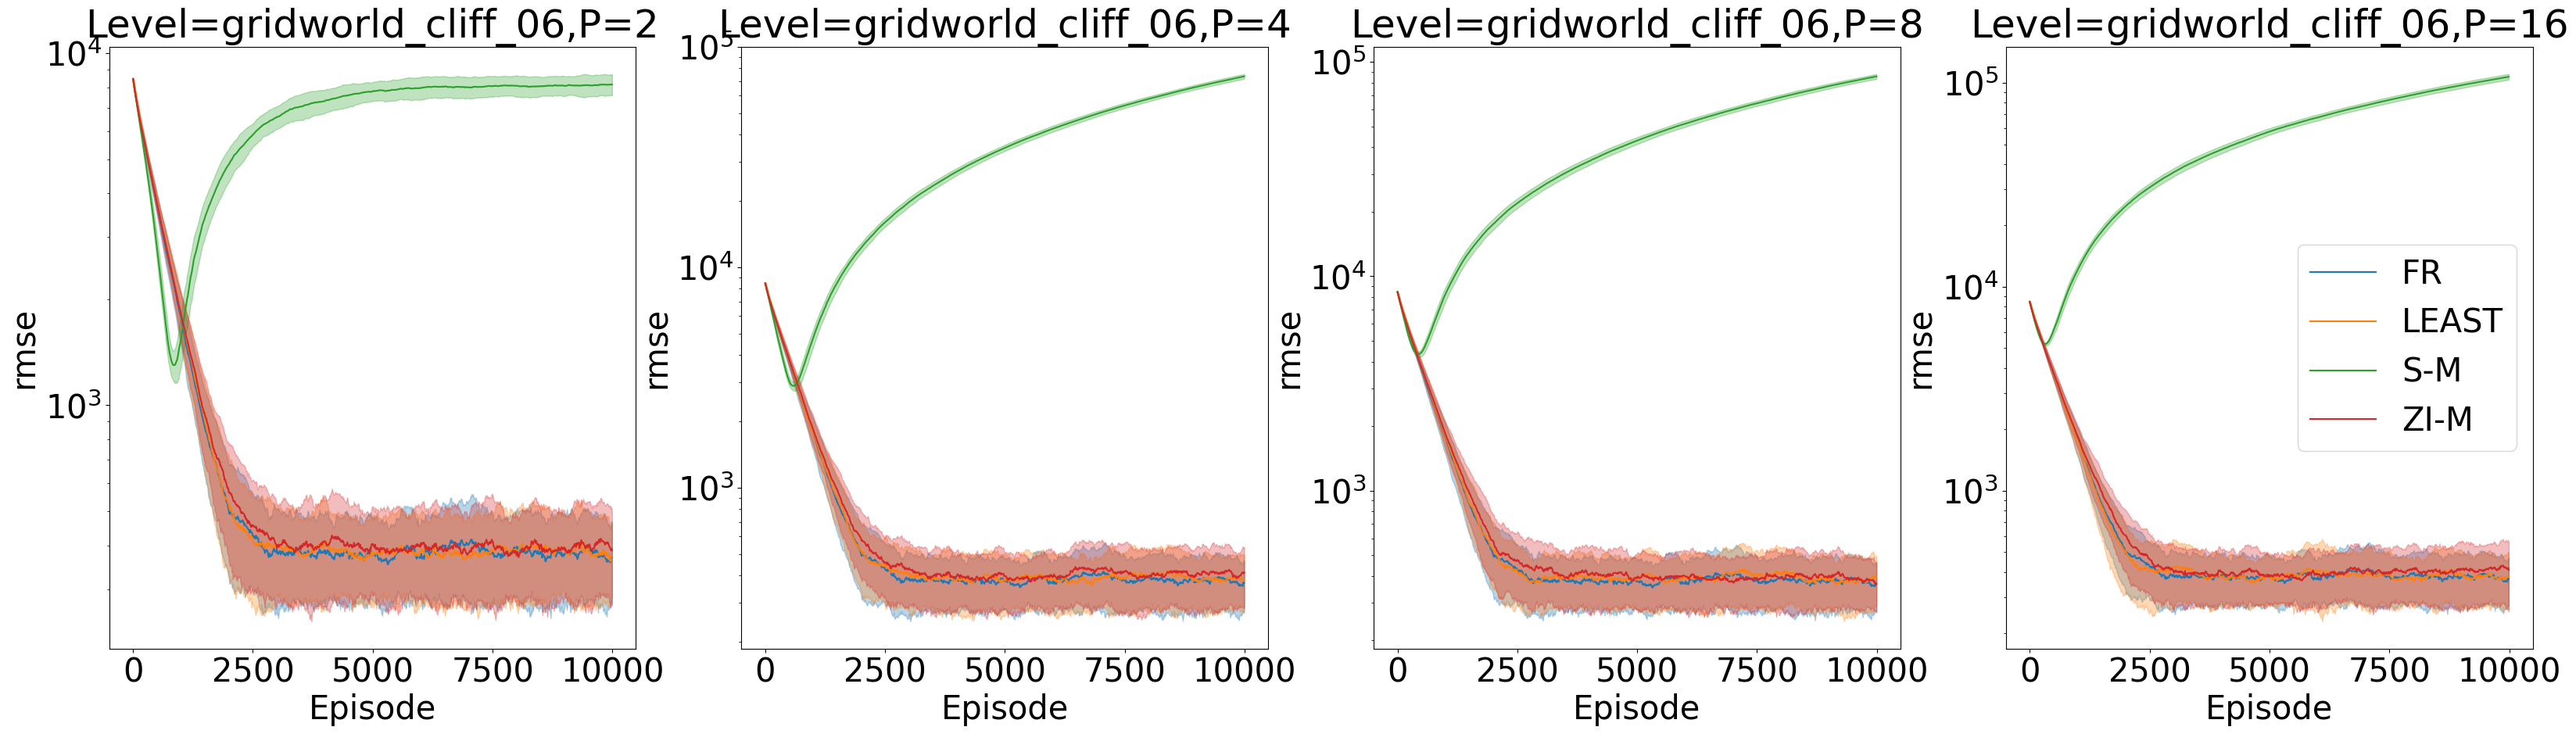

In [54]:
ax = utils.plot_multiple_configs(
    df_final,
    configs=[
        "Lgridworld_cliff_06-P2",
        "Lgridworld_cliff_06-P4",
        "Lgridworld_cliff_06-P8",
        "Lgridworld_cliff_06-P16",
    ],
    nrows=1,
    ncols=4,
    figsize=PLOT_SIZE,
    log_scale_y=True,
)
utils.export_figure(
    ax,
    "figures/cpr_v2/gridworld_cliff/gridworld_fixed_Lgridworld_cliff_06_change_Pxx",
    format="pdf",
)

In [55]:
utils.combine_table_config_comparisons(
    df_final,
    configs=[
        "Lgridworld_cliff_06-P2",
        "Lgridworld_cliff_06-P4",
        "Lgridworld_cliff_06-P8",
        "Lgridworld_cliff_06-P16",
    ],
)

config method  episode           rmse ± std  \
999    Lgridworld_cliff_06-P2     FR     9990       368.925±98.466   
2998   Lgridworld_cliff_06-P2  LEAST     9990       371.859±88.644   
2999   Lgridworld_cliff_06-P2    S-M     9990     8147.118±562.716   
2997   Lgridworld_cliff_06-P2   ZI-M     9990       386.37±113.761   
999    Lgridworld_cliff_06-P4     FR     9990       368.925±98.466   
2999   Lgridworld_cliff_06-P4  LEAST     9990      385.667±106.926   
2998   Lgridworld_cliff_06-P4    S-M     9990   73410.126±1790.885   
2997   Lgridworld_cliff_06-P4   ZI-M     9990      411.653±125.118   
999    Lgridworld_cliff_06-P8     FR     9990       368.925±98.466   
2998   Lgridworld_cliff_06-P8  LEAST     9990      392.516±103.936   
2997   Lgridworld_cliff_06-P8    S-M     9990   85570.962±2213.478   
2999   Lgridworld_cliff_06-P8   ZI-M     9990       365.728±94.659   
999   Lgridworld_cliff_06-P16     FR     9990       368.925±98.466   
2999  Lgridworld_cliff_06-P16  LEAST     9990      378.741±118.201   
2997  Lgridworld_cliff_06-P16    S-M     9990  107000.378±3418.922   
2998  Lgridworld_cliff_06-P16   ZI-M     9990      408.737±152.525   

     rmse (mean) rmse (std)  
999      368.925     98.466  
2998     371.859     88.644  
2999    8147.118    562.716  
2997      386.37    113.761  
999      368.925     98.466  
2999     385.667    106.926  
2998   73410.126   1790.885  
2997     411.653    125.118  
999      368.925     98.466  
2998     392.516    103.936  
2997   85570.962   2213.478  
2999     365.728     94.659  
999      368.925     98.466  
2999     378.741    118.201  
2997  107000.378   3418.922  
2998     408.737    152.525

## Mean Error

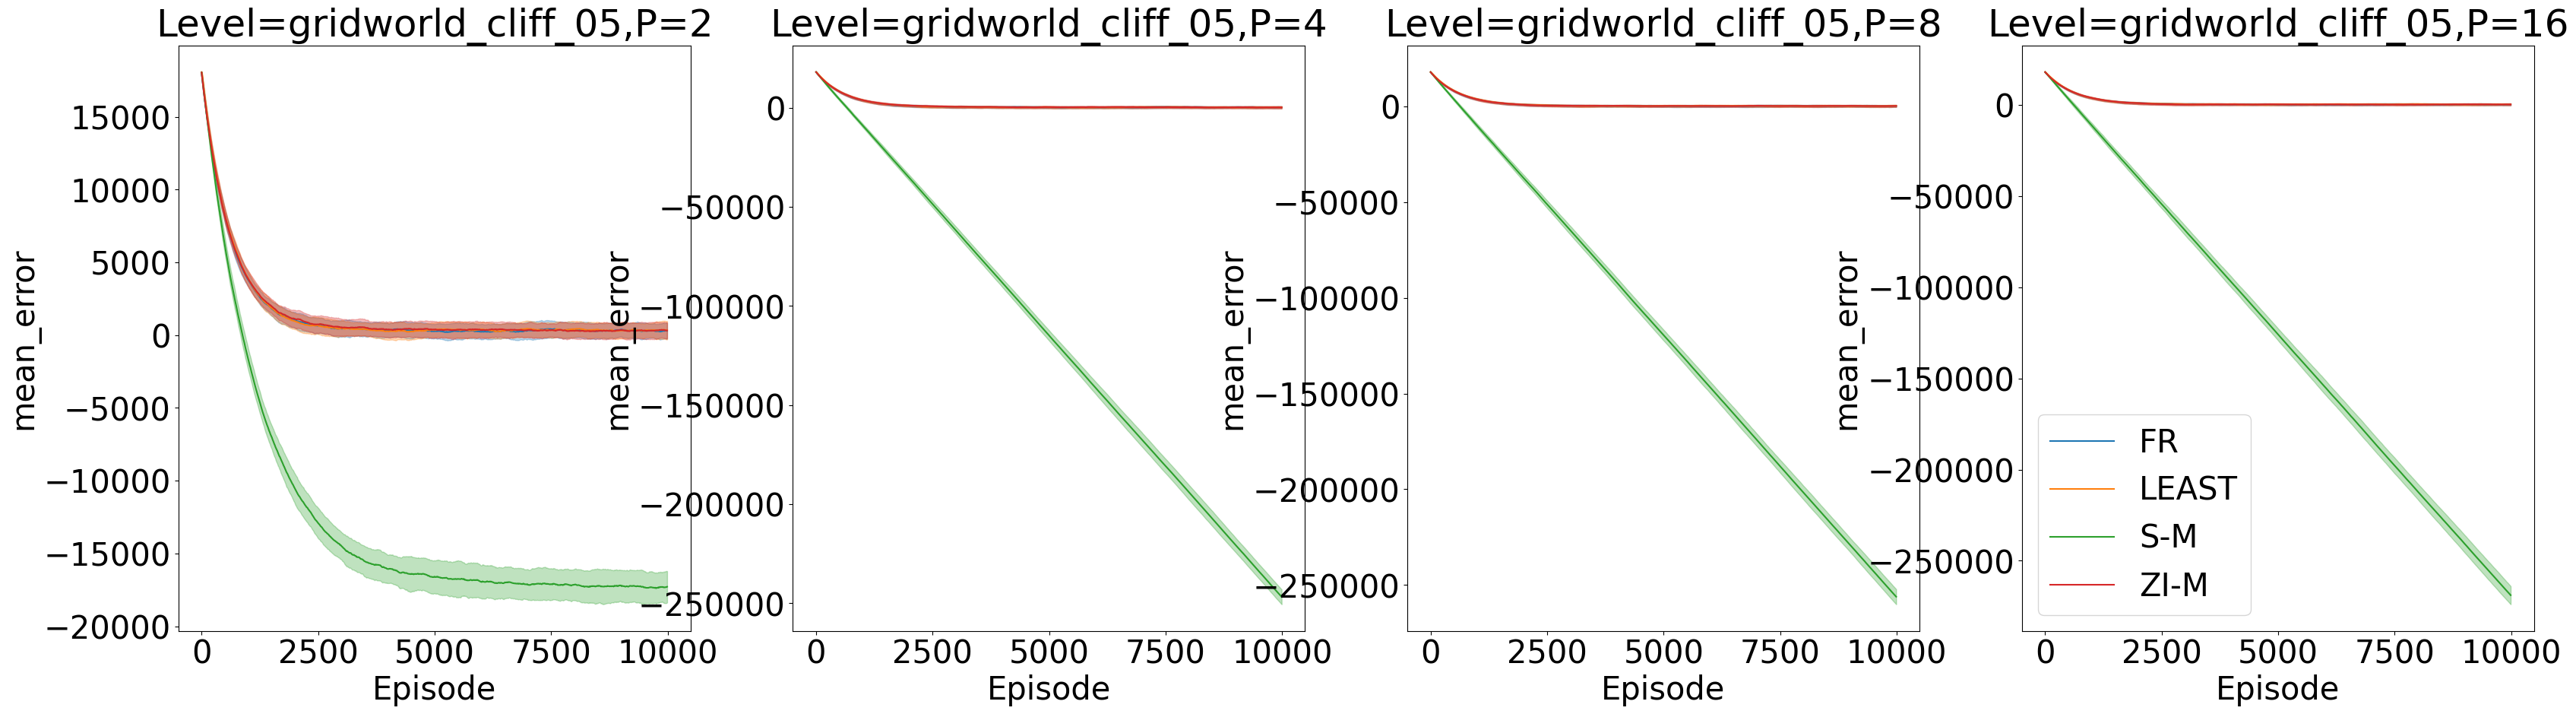

In [56]:
# One plot with mean error
ax = utils.plot_multiple_configs(
    df_final,
    configs=utils.get_configs(df_final, level="gridworld_cliff_05"),
    nrows=1,
    ncols=4,
    figsize=PLOT_SIZE,
    log_scale_y=False,
    metric="mean_error",
)
utils.export_figure(
    ax, "figures/cpr_v2/gridworld_cliff/gridworld_cliff_05_mean_error", format="pdf"
)

## Correlations

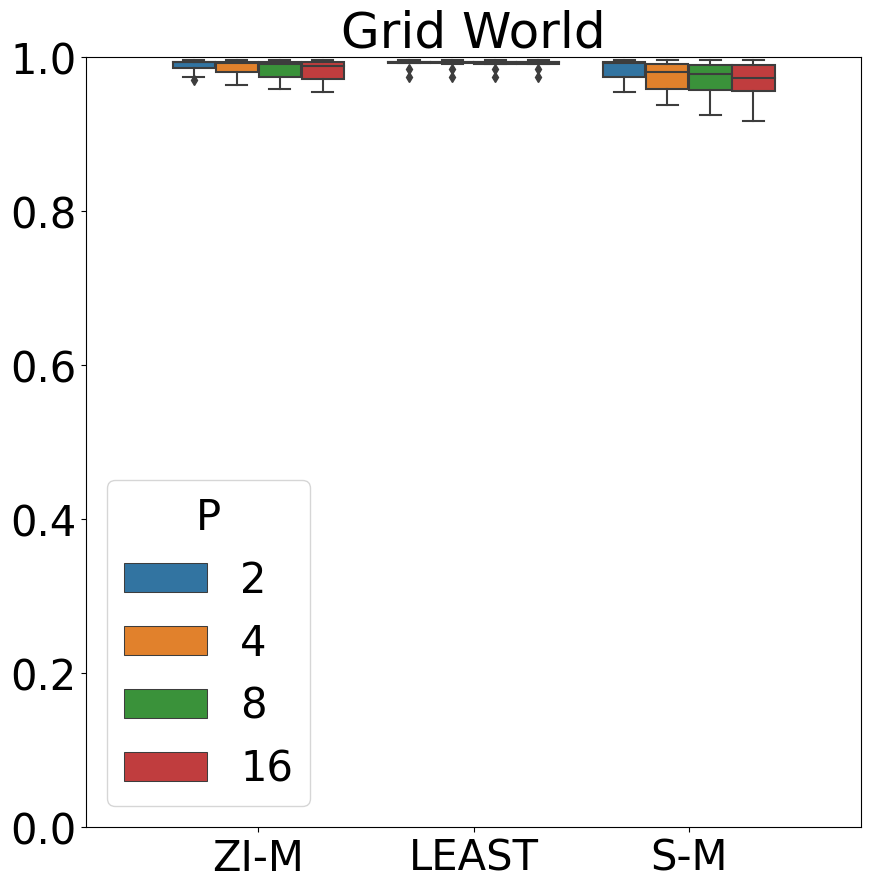

In [57]:
ax = utils.boxplot_corr(
    utils.final_episode_metrics(df_final, metric="spearman_corr"),
    metric="spearman_corr (mean)",
    title="Grid World",
)
utils.export_figure(
    ax, "figures/cpr_v2/gridworld_cliff/gridworld_cliff_spearman_corr", format="pdf"
)

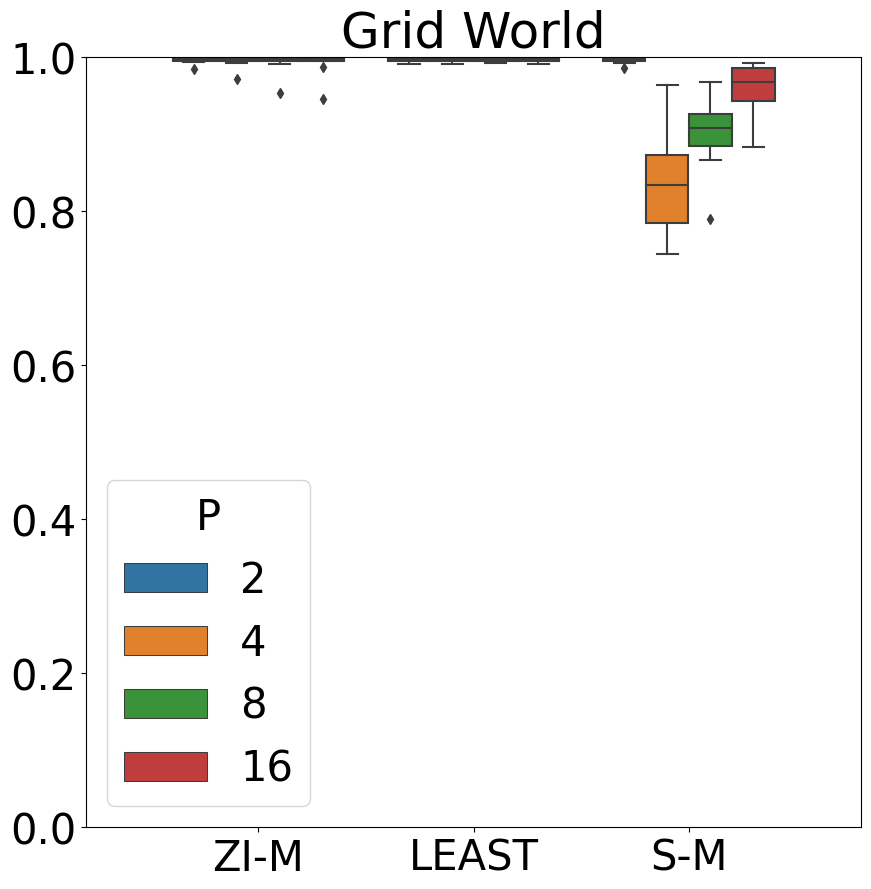

In [58]:
ax = utils.boxplot_corr(
    utils.final_episode_metrics(df_final, metric="pearson_corr"),
    metric="pearson_corr (mean)",
    title="Grid World",
)
utils.export_figure(
    ax, "figures/cpr_v2/gridworld_cliff/gridworld_cliff_pearson_corr", format="pdf"
)

## Q-Tables

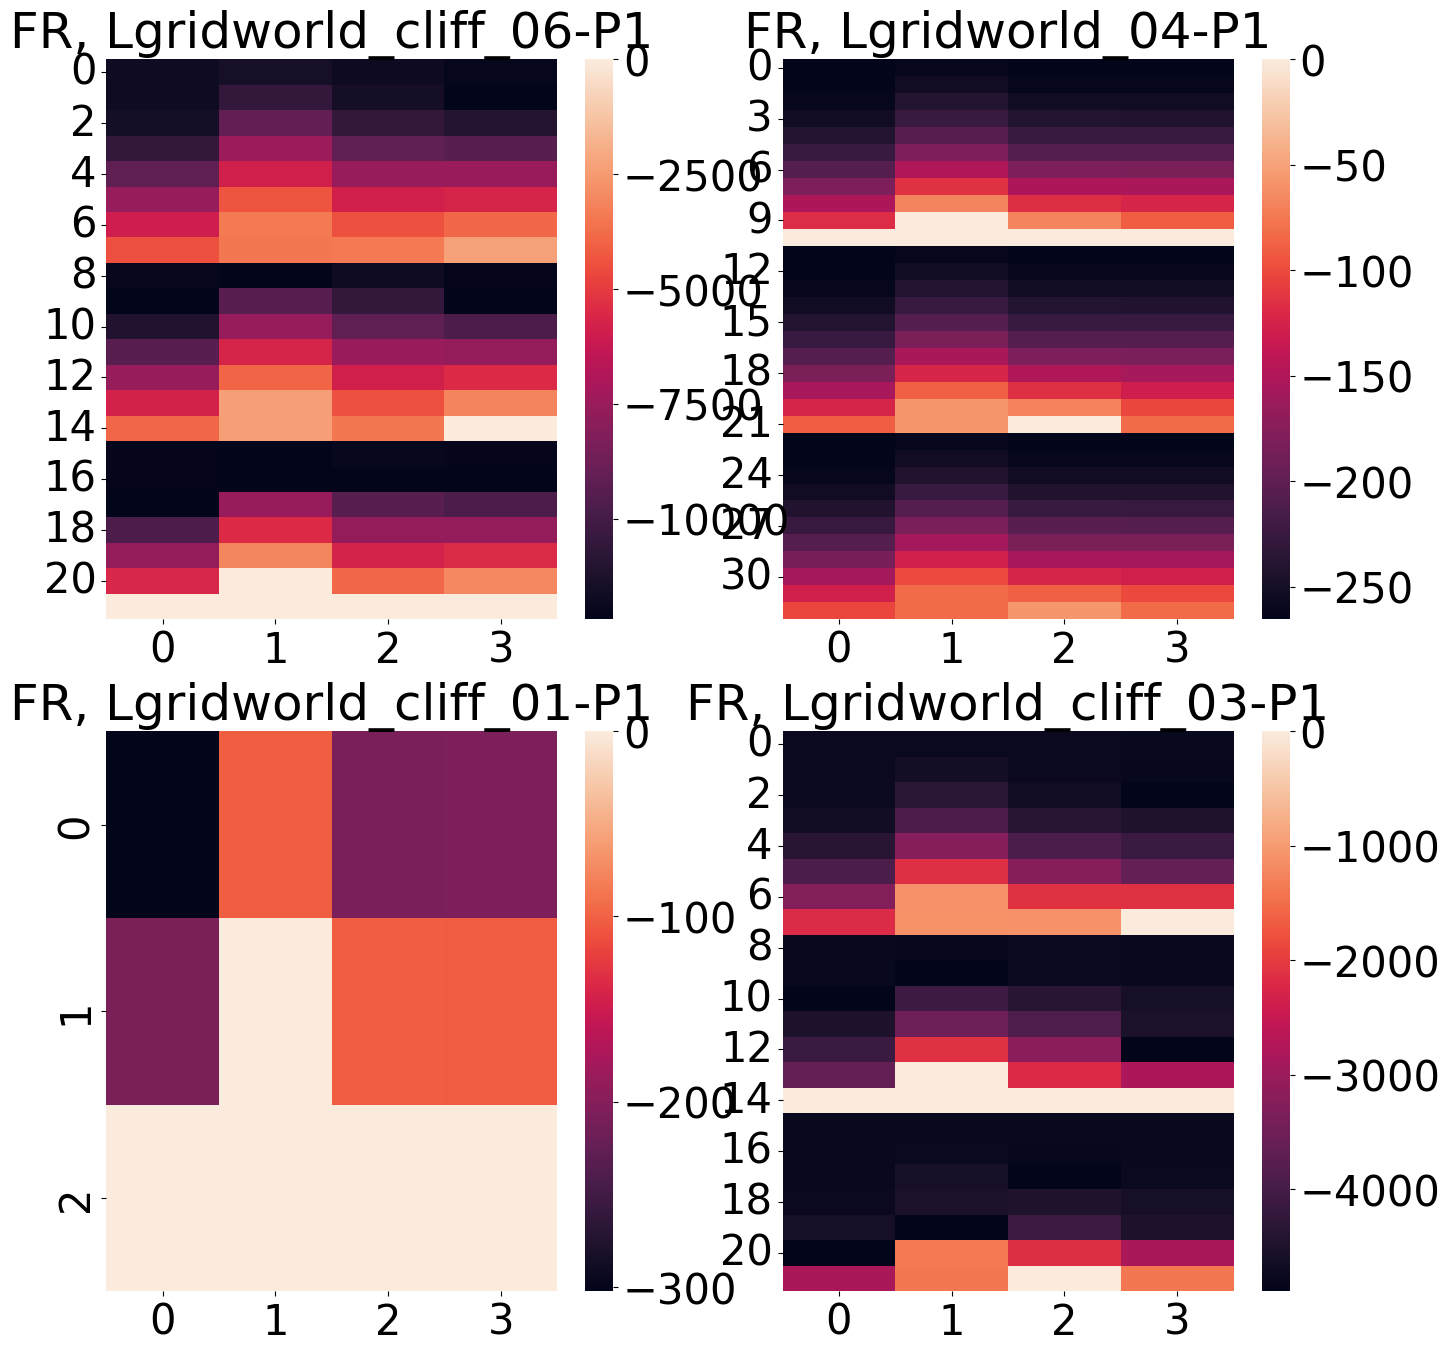

In [59]:
_ = utils.qtable_sample_heatmaps(df_final, method="FR", figsize=(16, 16))

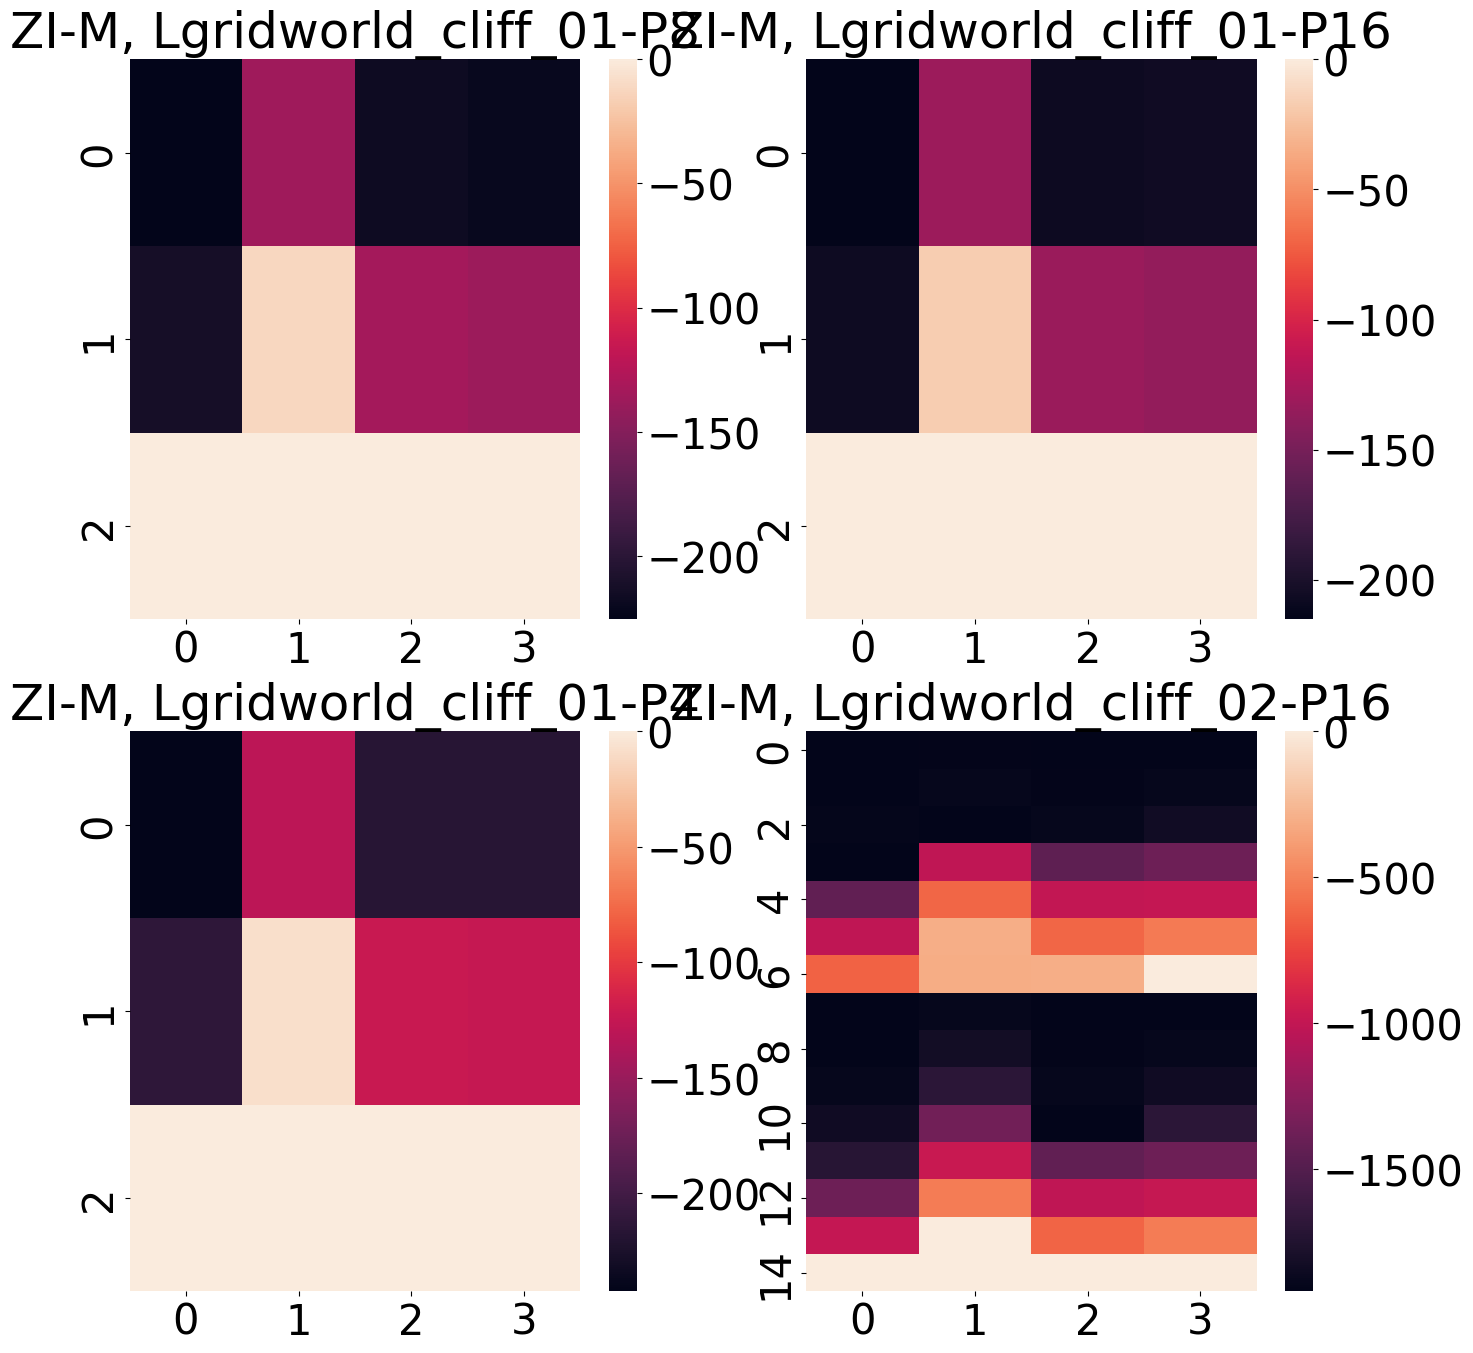

In [60]:
_ = utils.qtable_sample_heatmaps(df_final, method="ZI-M", figsize=(16, 16))

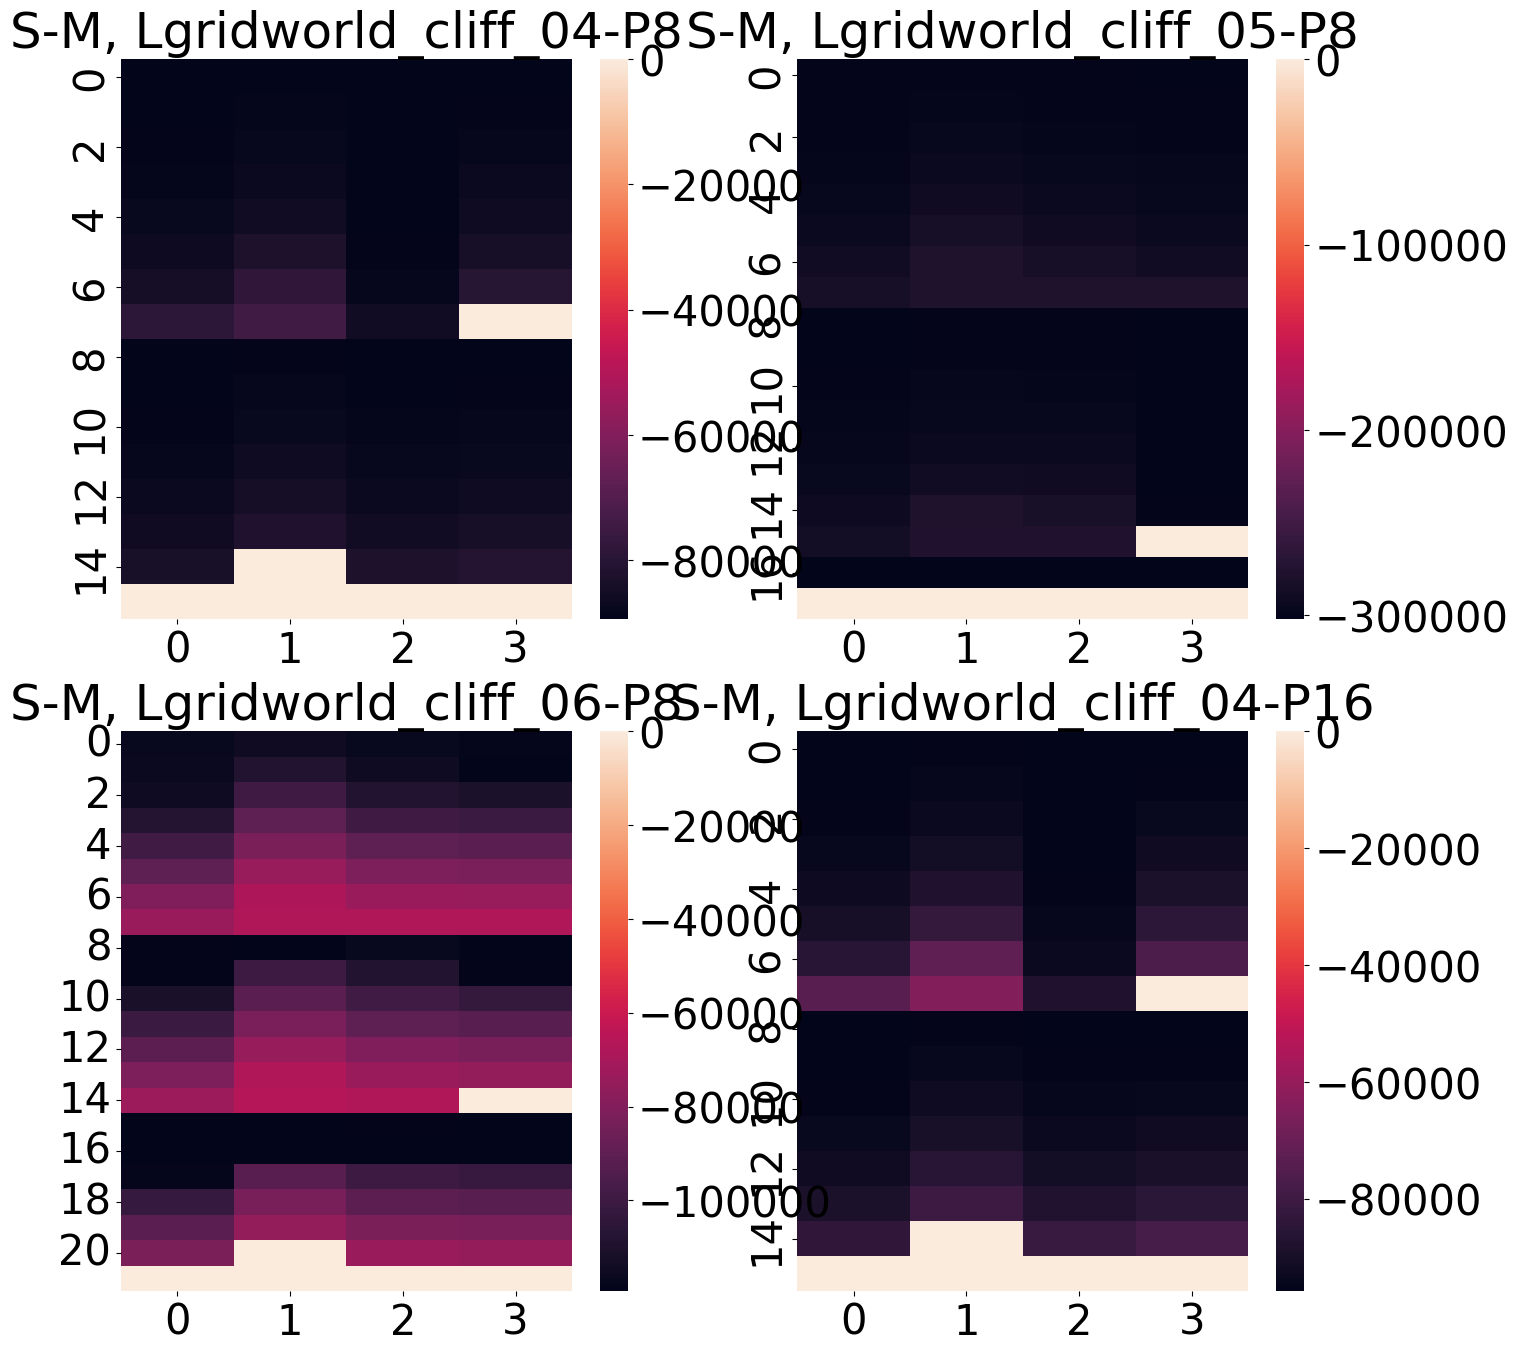

In [61]:
_ = utils.qtable_sample_heatmaps(df_final, method="S-M", figsize=(16, 16))

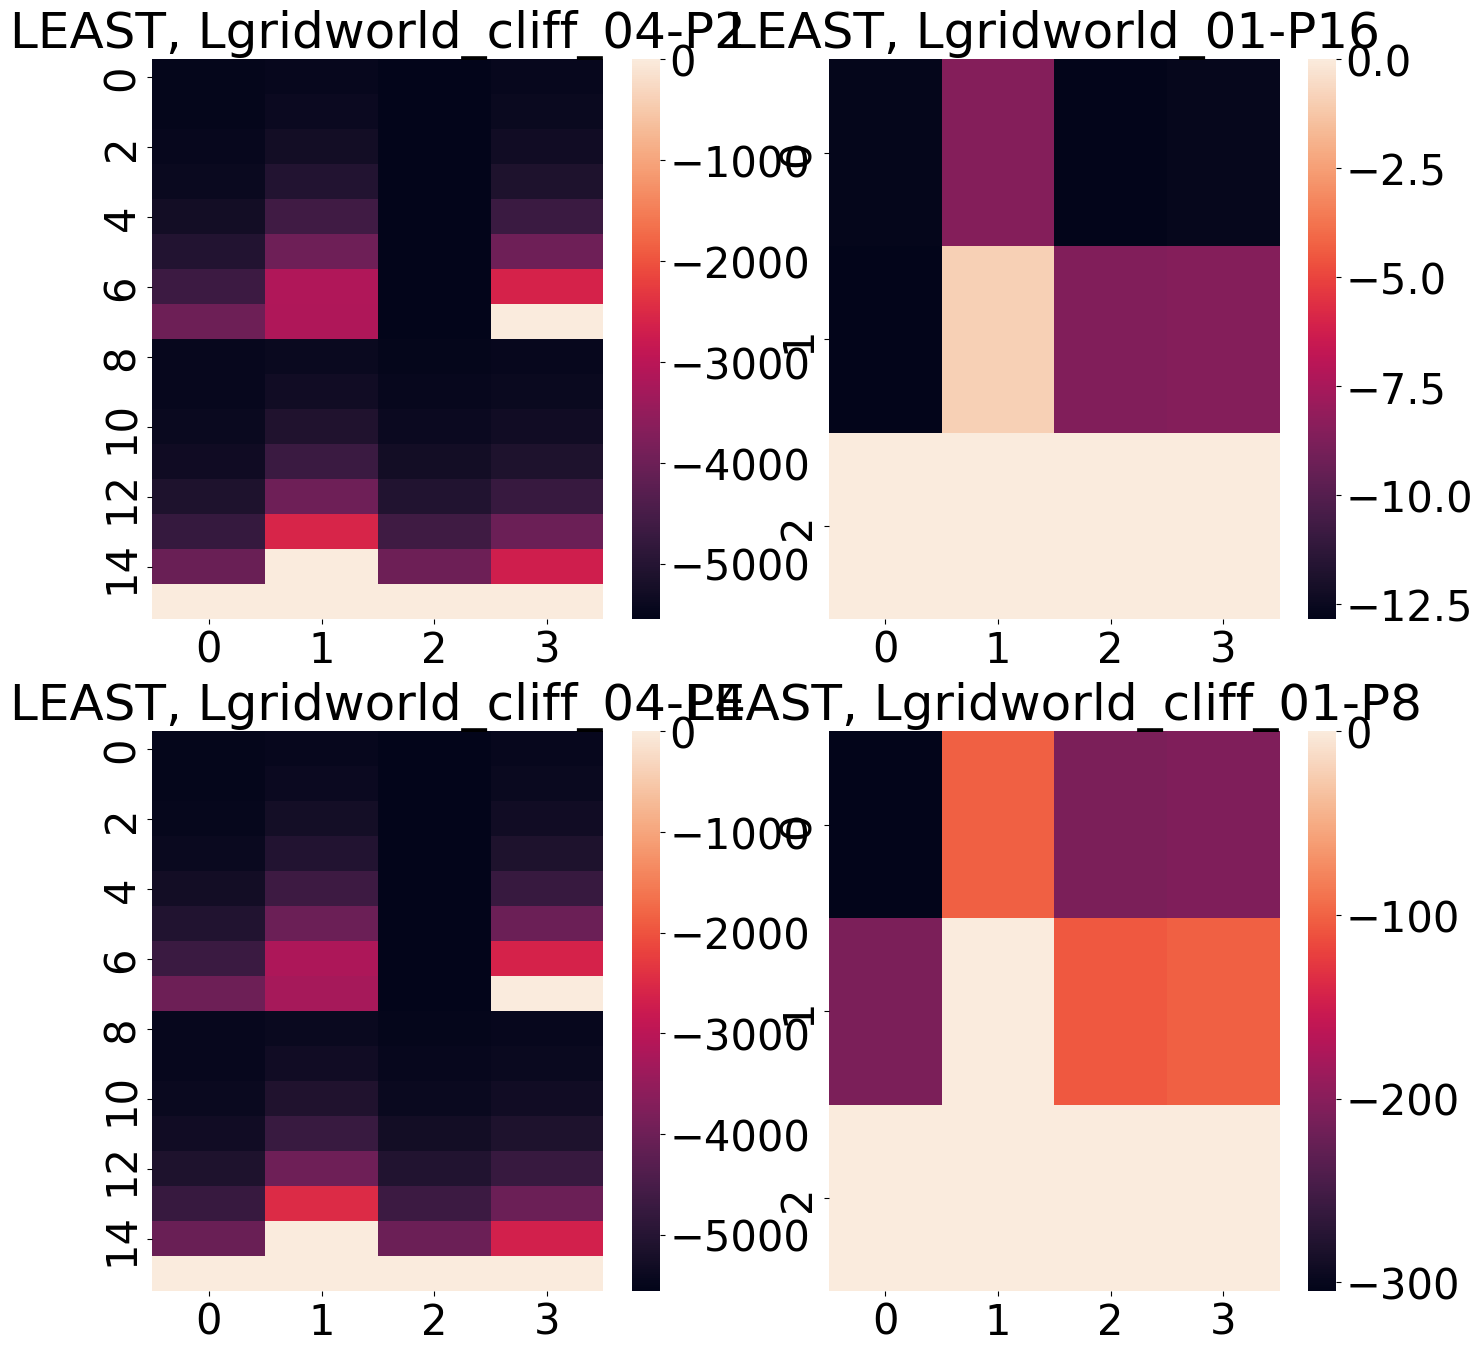

In [62]:
_ = utils.qtable_sample_heatmaps(df_final, method="LEAST", figsize=(16, 16))

## Results Table

In [63]:
experiments

{'gridworld_01': [1, 2, 4, 8, 16],
 'gridworld_02': [1, 2, 4, 8, 16],
 'gridworld_03': [1, 2, 4, 8, 16],
 'gridworld_04': [1, 2, 4, 8, 16],
 'gridworld_cliff_01': [1, 2, 4, 8, 16],
 'gridworld_cliff_02': [1, 2, 4, 8, 16],
 'gridworld_cliff_03': [1, 2, 4, 8, 16],
 'gridworld_cliff_04': [1, 2, 4, 8, 16],
 'gridworld_cliff_05': [1, 2, 4, 8, 16],
 'gridworld_cliff_06': [1, 2, 4, 8, 16]}

In [64]:
df_rmse_results = utils.metric_results_table(
    df_final, metric="rmse", experiments=experiments, level_transform_fn=lambda x: x
)

In [65]:
df_rmse_results

method           Level/Map   P              FR                  S-M  \
1             gridworld_01   2     0.794±0.289          6.611±1.098   
2             gridworld_01   4     0.794±0.289       829.452±11.684   
3             gridworld_01   8     0.794±0.289       582.113±12.295   
0             gridworld_01  16     0.794±0.289       255.516±10.338   
5             gridworld_02   2     6.826±2.471       151.746±11.192   
6             gridworld_02   4     6.826±2.471      3278.365±57.096   
7             gridworld_02   8     6.826±2.471      3631.848±70.689   
4             gridworld_02  16     6.826±2.471      3892.926±85.311   
9             gridworld_03   2     6.558±2.079        191.787±8.722   
10            gridworld_03   4     6.558±2.079      1325.788±17.414   
11            gridworld_03   8     6.558±2.079      1426.788±21.406   
8             gridworld_03  16     6.558±2.079      1541.833±23.052   
13            gridworld_04   2     6.655±1.795        192.357±8.715   
14            gridworld_04   4     6.655±1.795      1322.079±23.193   
15            gridworld_04   8     6.655±1.795      1424.107±24.225   
12            gridworld_04  16     6.655±1.795      1544.188±21.589   
17      gridworld_cliff_01   2    17.951±6.268        146.72±30.606   
18      gridworld_cliff_01   4    17.951±6.268    15464.607±301.918   
19      gridworld_cliff_01   8    17.951±6.268     10844.884±297.05   
16      gridworld_cliff_01  16    17.951±6.268     4669.388±237.253   
21      gridworld_cliff_02   2   76.207±21.883     1422.375±112.609   
22      gridworld_cliff_02   4   76.207±21.883     18701.14±472.262   
23      gridworld_cliff_02   8   76.207±21.883    23526.073±552.762   
20      gridworld_cliff_02  16   76.207±21.883    28970.506±776.073   
25      gridworld_cliff_03   2  172.776±36.944     3855.196±232.795   
26      gridworld_cliff_03   4  172.776±36.944    37117.598±799.424   
27      gridworld_cliff_03   8  172.776±36.944     44724.537±890.64   
24      gridworld_cliff_03  16  172.776±36.944    51003.109±921.199   
29      gridworld_cliff_04   2  208.273±60.757     4507.072±259.136   
30      gridworld_cliff_04   4  208.273±60.757   72255.124±1089.877   
31      gridworld_cliff_04   8  208.273±60.757   77846.179±1261.022   
28      gridworld_cliff_04  16  208.273±60.757   81423.459±1497.639   
33      gridworld_cliff_05   2  745.885±277.91    18195.32±1118.722   
34      gridworld_cliff_05   4  745.885±277.91  255804.832±3890.733   
35      gridworld_cliff_05   8  745.885±277.91    265567.7±4103.359   
32      gridworld_cliff_05  16  745.885±277.91  279066.206±5158.172   
37      gridworld_cliff_06   2  368.925±98.466     8147.118±562.716   
38      gridworld_cliff_06   4  368.925±98.466   73410.126±1790.885   
39      gridworld_cliff_06   8  368.925±98.466   85570.962±2213.478   
36      gridworld_cliff_06  16  368.925±98.466  107000.378±3418.922   

method             ZI-M            LEAST  
1            0.942±0.36      0.779±0.308  
2           1.033±0.342      0.862±0.327  
3           1.134±0.437       0.804±0.36  
0           1.273±0.454        0.8±0.311  
5            7.68±3.116      8.143±3.325  
6           7.999±3.106      7.366±3.248  
7           7.205±2.769      7.519±3.097  
4           8.232±3.475      8.054±3.105  
9           6.235±1.675      6.127±1.569  
10           6.29±1.716       6.11±1.462  
11          6.524±1.777      6.261±1.613  
8            6.389±1.76      6.498±1.904  
13          6.159±1.593      6.467±1.838  
14          6.247±1.404      6.306±1.718  
15          6.397±1.784      6.596±1.864  
12           6.399±1.78      6.553±1.962  
17         23.908±7.277     18.358±7.056  
18         29.085±7.457     18.786±7.001  
19         34.247±7.233     18.786±8.061  
16          36.61±9.242     18.107±7.386  
21        83.367±29.428    76.366±23.349  
22         84.27±27.786     73.57±20.862  
23        92.333±32.612    76.301±22.312  
20        84.322±26.027     78.06±29.346  
25       175.

In [66]:
utils.highlight_min_result(df_rmse_results, cols=["S-M", "ZI-M", "LEAST"])

method           Level/Map   P              FR                  S-M  \
1             gridworld_01   2     0.794±0.289          6.611±1.098   
2             gridworld_01   4     0.794±0.289       829.452±11.684   
3             gridworld_01   8     0.794±0.289       582.113±12.295   
0             gridworld_01  16     0.794±0.289       255.516±10.338   
5             gridworld_02   2     6.826±2.471       151.746±11.192   
6             gridworld_02   4     6.826±2.471      3278.365±57.096   
7             gridworld_02   8     6.826±2.471      3631.848±70.689   
4             gridworld_02  16     6.826±2.471      3892.926±85.311   
9             gridworld_03   2     6.558±2.079        191.787±8.722   
10            gridworld_03   4     6.558±2.079      1325.788±17.414   
11            gridworld_03   8     6.558±2.079      1426.788±21.406   
8             gridworld_03  16     6.558±2.079      1541.833±23.052   
13            gridworld_04   2     6.655±1.795        192.357±8.715   
14            gridworld_04   4     6.655±1.795      1322.079±23.193   
15            gridworld_04   8     6.655±1.795      1424.107±24.225   
12            gridworld_04  16     6.655±1.795      1544.188±21.589   
17      gridworld_cliff_01   2    17.951±6.268        146.72±30.606   
18      gridworld_cliff_01   4    17.951±6.268    15464.607±301.918   
19      gridworld_cliff_01   8    17.951±6.268     10844.884±297.05   
16      gridworld_cliff_01  16    17.951±6.268     4669.388±237.253   
21      gridworld_cliff_02   2   76.207±21.883     1422.375±112.609   
22      gridworld_cliff_02   4   76.207±21.883     18701.14±472.262   
23      gridworld_cliff_02   8   76.207±21.883    23526.073±552.762   
20      gridworld_cliff_02  16   76.207±21.883    28970.506±776.073   
25      gridworld_cliff_03   2  172.776±36.944     3855.196±232.795   
26      gridworld_cliff_03   4  172.776±36.944    37117.598±799.424   
27      gridworld_cliff_03   8  172.776±36.944     44724.537±890.64   
24      gridworld_cliff_03  16  172.776±36.944    51003.109±921.199   
29      gridworld_cliff_04   2  208.273±60.757     4507.072±259.136   
30      gridworld_cliff_04   4  208.273±60.757   72255.124±1089.877   
31      gridworld_cliff_04   8  208.273±60.757   77846.179±1261.022   
28      gridworld_cliff_04  16  208.273±60.757   81423.459±1497.639   
33      gridworld_cliff_05   2  745.885±277.91    18195.32±1118.722   
34      gridworld_cliff_05   4  745.885±277.91  255804.832±3890.733   
35      gridworld_cliff_05   8  745.885±277.91    265567.7±4103.359   
32      gridworld_cliff_05  16  745.885±277.91  279066.206±5158.172   
37      gridworld_cliff_06   2  368.925±98.466     8147.118±562.716   
38      gridworld_cliff_06   4  368.925±98.466   73410.126±1790.885   
39      gridworld_cliff_06   8  368.925±98.466   85570.962±2213.478   
36      gridworld_cliff_06  16  368.925±98.466  107000.378±3418.922   

method                     ZI-M                     LEAST  
1                    0.942±0.36      \textbf{0.779±0.308}  
2                   1.033±0.342      \textbf{0.862±0.327}  
3                   1.134±0.437       \textbf{0.804±0.36}  
0                   1.273±0.454        \textbf{0.8±0.311}  
5           \textbf{7.68±3.116}               8.143±3.325  
6                   7.999±3.106      \textbf{7.366±3.248}  
7          \textbf{7.205±2.769}               7.519±3.097  
4                   8.232±3.475      \textbf{8.054±3.105}  
9                   6.235±1.675      \textbf{6.127±1.569}  
10                   6.29±1.716       \textbf{6.11±1.462}  
11                  6.524±1.777      \textbf{6.261±1.613}  
8           \textbf{6.389±1.76}               6.498±1.904  
13         \textbf{6.159±1.593}               6.467±1.838  
14         \textbf{6.247±1.404}               6.306±1.718  
15         \textbf{6.397±1.784}               6.596±1.864  
12          \textbf{6.399±1.78}               6.553±1.962  
17                 23.908±7.277     \textbf{18.358±7.056}  
18      

In [67]:
print(
    utils.highlight_min_result(df_rmse_results, cols=["S-M", "ZI-M", "LEAST"]).to_latex(
        index=False, col_space=3, escape=False
    )
)

\begin{tabular}{lrllll}
\toprule
         Level/Map &   P &             FR &                 S-M &                    ZI-M &                    LEAST \\
\midrule
      gridworld_01 &   2 &    0.794±0.289 &         6.611±1.098 &              0.942±0.36 &     \textbf{0.779±0.308} \\
      gridworld_01 &   4 &    0.794±0.289 &      829.452±11.684 &             1.033±0.342 &     \textbf{0.862±0.327} \\
      gridworld_01 &   8 &    0.794±0.289 &      582.113±12.295 &             1.134±0.437 &      \textbf{0.804±0.36} \\
      gridworld_01 &  16 &    0.794±0.289 &      255.516±10.338 &             1.273±0.454 &       \textbf{0.8±0.311} \\
      gridworld_02 &   2 &    6.826±2.471 &      151.746±11.192 &     \textbf{7.68±3.116} &              8.143±3.325 \\
      gridworld_02 &   4 &    6.826±2.471 &     3278.365±57.096 &             7.999±3.106 &     \textbf{7.366±3.248} \\
      gridworld_02 &   8 &    6.826±2.471 &     3631.848±70.689 &    \textbf{7.205±2.769} &              7.519±3.097 \

/var/folders/x6/dhj0wxhd29b9j0rrjt_xxh0c0000gn/T/ipykernel_31139/1089978551.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(utils.highlight_min_result(df_rmse_results, cols=["S-M", "ZI-M", "LEAST"]).to_latex(index=False, col_space=3, escape=False))


In [68]:
print(
    utils.highlight_min_result(df_rmse_results, cols=["S-M", "ZI-M", "LEAST"])
    .drop(["FR"], axis=1)
    .to_latex(index=False, col_space=3, escape=False)
)

\begin{tabular}{lrlll}
\toprule
         Level/Map &   P &                 S-M &                    ZI-M &                    LEAST \\
\midrule
      gridworld_01 &   2 &         6.611±1.098 &              0.942±0.36 &     \textbf{0.779±0.308} \\
      gridworld_01 &   4 &      829.452±11.684 &             1.033±0.342 &     \textbf{0.862±0.327} \\
      gridworld_01 &   8 &      582.113±12.295 &             1.134±0.437 &      \textbf{0.804±0.36} \\
      gridworld_01 &  16 &      255.516±10.338 &             1.273±0.454 &       \textbf{0.8±0.311} \\
      gridworld_02 &   2 &      151.746±11.192 &     \textbf{7.68±3.116} &              8.143±3.325 \\
      gridworld_02 &   4 &     3278.365±57.096 &             7.999±3.106 &     \textbf{7.366±3.248} \\
      gridworld_02 &   8 &     3631.848±70.689 &    \textbf{7.205±2.769} &              7.519±3.097 \\
      gridworld_02 &  16 &     3892.926±85.311 &             8.232±3.475 &     \textbf{8.054±3.105} \\
      gridworld_03 &   2 &      

/var/folders/x6/dhj0wxhd29b9j0rrjt_xxh0c0000gn/T/ipykernel_31139/2678292717.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(utils.highlight_min_result(df_rmse_results, cols=["S-M", "ZI-M", "LEAST"]).drop(["FR"], axis=1).to_latex(index=False, col_space=3, escape=False))
